In [26]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import box

#PATHs
glacliers_path = "glamos/glacier_list.csv"
shape_path_2010 = "glamos/2010/SGI_2010.shp"
shape_path_2016 = "glamos/2016/SGI_2016_glaciers.shp"

sgi_2016 = gpd.read_file(shape_path_2016)

# Attributes of the shape file
print(sgi_2016.columns)

Index(['gid', 'pk_glacier', 'sgi-id', 'name', 'rl_0', 'rl_1', 'rl_2', 'rl_3',
       'i_code', 'year_acq', 'year_rel', 'area_km2', 'length_km', 'masl_min',
       'masl_med', 'masl_mean', 'masl_max', 'slope_deg', 'aspect_deg',
       'geometry'],
      dtype='object')


In [27]:
import geopandas as gpd

# 1. Charger ton shapefile (assure-toi d'avoir le fichier .prj ou de définir le CRS)
gdf = gpd.read_file(shape_path_2016)

# 2. Définir le CRS source si ce n'est pas détecté (LV95 = EPSG:2056)
if gdf.crs is None:
    gdf.set_crs(epsg=2056, inplace=True)

# 3. Reprojeter vers WGS84 (requis par GEE)
gdf_wgs84 = gdf.to_crs(epsg=4326)

# 4. Sauvegarder pour l'upload dans GEE
gdf_wgs84.to_file("glamos/SGI_2016_wgs84.shp")

Sentiel does not exist in early 2016...

In [41]:
# Filter out 2016 glaciers
count_before = len(sgi_2016[sgi_2016["year_acq"] <= 2016])
sgi = sgi_2016[sgi_2016["year_acq"] >= 2016]
print(f"Removed {count_before - len(sgi)} glaciers acquired in 2016. ({(count_before - len(sgi)) / count_before * 100:.2f}%)")

Removed 64 glaciers acquired in 2016. (6.39%)


In [40]:
import ee
import geemap
import geopandas as gpd
from shapely.geometry import box
import os
import numpy as np

# Initialisation
try:
    ee.Initialize(project="b3testdrive")
except Exception:
    ee.Authenticate()
    ee.Initialize(project="b3testdrive")

# --- Configuration Scientifique ---
TILE_SIZE_PX = 224
RESOLUTION = 10 
TILE_SIZE_M = TILE_SIZE_PX * RESOLUTION  # 2240m
OUTPUT_DIR = "dataset/images_raw_2056"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Seuils
MIN_INTERSECTION_M2 = 5000
MIN_YEAR = 2015 

# 1. Chargement en EPSG:2056 (Système Suisse Natif)
# Si ton fichier est déjà en 2056, super. Sinon on convertit.
print("Chargement des données...")
gdf = gpd.read_file("glamos/SGI_2016_wgs84.shp")
if gdf.crs.to_epsg() != 2056:
    gdf = gdf.to_crs(epsg=2056)

def get_sentinel_raw(year):
    """
    Récupère les données brutes (Reflectance).
    Pas de .visualize() ! On veut les données scientifiques.
    """
    start = f'{year}-07-01'
    end = f'{year}-09-30'
    
    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterDate(start, end) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .median() # Médiane pour enlever les nuages
    
    # Sélection des bandes : Bleu, Vert, Rouge, Proche Infrarouge (NIR)
    # B2, B3, B4 sont le visible. B8 est CRUCIAL pour les glaciers.
    return collection.select(['B2', 'B3', 'B4', 'B8'])

# Stats
stats = { "tiles_kept": 0, "errors": 0 }

print(f"Début du traitement en EPSG:2056...")

for index, row in gdf.iterrows():
    g_id = row['pk_glacier']
    year = row['year_acq']
    
    if year < MIN_YEAR: continue 

    # Géométrie en mètres suisses (LV95)
    geom_shapely = row.geometry
    minx, miny, maxx, maxy = geom_shapely.bounds
    
    # Grille basée sur le système métrique suisse
    x_coords = np.arange(minx, maxx, TILE_SIZE_M)
    y_coords = np.arange(miny, maxy, TILE_SIZE_M)
    
    local_cnt = 0
    
    for x in x_coords:
        for y in y_coords:
            # Création tuile locale
            tile_box = box(x, y, x + TILE_SIZE_M, y + TILE_SIZE_M)
            
            # Filtres locaux
            if not tile_box.intersects(geom_shapely): continue
            if tile_box.intersection(geom_shapely).area < MIN_INTERSECTION_M2: continue
            
            filename = os.path.join(OUTPUT_DIR, f"{g_id}_{year}_tile_{local_cnt}.tif")
            if os.path.exists(filename): 
                local_cnt += 1
                continue
            
            # --- LA PARTIE CLE : GESTION DE LA PROJECTION ---
            
            # 1. On définit la région en EPSG:2056 (LV95)
            # GEE ne supporte pas 2056 nativement dans tous les constructeurs Geometry, 
            # mais on peut lui forcer la main lors de l'export.
            
            # Astuce : Pour définir la region pour GEE, on doit souvent repasser en WGS84 (EPSG:4326)
            # car ee.Geometry.Rectangle aime bien la lat/lon par défaut.
            # MAIS on demandera l'export final en 2056.
            
            # Conversion de la boite courante (2056) vers WGS84 juste pour la requête
            box_gdf = gpd.GeoSeries([tile_box], crs=2056)
            box_wgs84 = box_gdf.to_crs(epsg=4326).iloc[0]
            
            region_ee = ee.Geometry.Rectangle(
                [box_wgs84.bounds[0], box_wgs84.bounds[1], box_wgs84.bounds[2], box_wgs84.bounds[3]],
                proj='EPSG:4326',
                geodesic=False
            )
            
            try:
                # Téléchargement
                geemap.download_ee_image(
                    get_sentinel_raw(int(year)),
                    filename=filename,
                    region=region_ee,   # La zone géographique
                    scale=10,           # 10 mètres par pixel
                    crs='EPSG:2056',    # ON FORCE LA PROJECTION SUISSE ICI
                    dtype='uint16'      # On garde le format compact (0-10000)
                )
                stats["tiles_kept"] += 1
                local_cnt += 1
                
            except Exception as e:
                print(f"Erreur {g_id}: {e}")
                stats["errors"] += 1

print(f"Terminé. Tuiles générées : {stats['tiles_kept']}")

Chargement des données...
Début du traitement en EPSG:2056...


...f6be00-4ec8-11e8-85b0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f6be00-4ec8-11e8-85b0-985fd331b2ee_2016_tile_1.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f6be00-4ec8-11e8-85b0-985fd331b2ee_2016_tile_2.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f6be00-4ec8-11e8-85b0-985fd331b2ee_2016_tile_3.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...e3ab30-4ec8-11e8-9357-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...9e16ae-4ec8-11e8-a93d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...d9e72e-4ec8-11e8-8c0d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...db6dd1-4ec8-11e8-ba3c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...694b0f-4ec8-11e8-8cf0-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...7e32a1-4ec8-11e8-8f72-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...82ed8f-4ec8-11e8-ae59-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8bee40-4ec8-11e8-ad08-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8bee40-4ec8-11e8-ad08-985fd331b2ee_2016_tile_1.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8bee40-4ec8-11e8-ad08-985fd331b2ee_2016_tile_2.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8bee40-4ec8-11e8-ad08-985fd331b2ee_2016_tile_3.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...ea1eb0-4ec8-11e8-a204-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...7c84ee-4ec8-11e8-8f0d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...e90d40-4ec8-11e8-b048-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...80075e-4ec8-11e8-807a-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...8389cf-4ec8-11e8-964a-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...2c854f-4ec8-11e8-8cbf-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9256e1-4ec8-11e8-9ecd-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...e786a1-4ec8-11e8-8120-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...2cfa80-4ec8-11e8-8469-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...e7fbd1-4ec8-11e8-a90e-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...a4a65e-4ec8-11e8-8822-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...311930-4ec8-11e8-b222-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...2ef64f-4ec8-11e8-889e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...ec1a80-4ec8-11e8-8d89-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...99d0f0-4ec8-11e8-8a6f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...b775f0-4ec8-11e8-b458-985fd331b2ee_2015_tile_0.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:   …

...affbde-4ec8-11e8-a21c-985fd331b2ee_2015_tile_0.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:   …

...aac0e1-4ec8-11e8-95fc-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...aa72c0-4ec8-11e8-bdc4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...e33600-4ec8-11e8-a46b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...dea221-4ec8-11e8-ad0c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...e1fd80-4ec8-11e8-8ae5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...caf311-4ec8-11e8-bbf5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...d04a40-4ec8-11e8-9ab1-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...dc0a0f-4ec8-11e8-99e8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...dc0a0f-4ec8-11e8-99e8-985fd331b2ee_2016_tile_1.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...dc0a0f-4ec8-11e8-99e8-985fd331b2ee_2016_tile_2.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...dc0a0f-4ec8-11e8-99e8-985fd331b2ee_2016_tile_3.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...dc0a0f-4ec8-11e8-99e8-985fd331b2ee_2016_tile_4.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...dc0a0f-4ec8-11e8-99e8-985fd331b2ee_2016_tile_5.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...dc0a0f-4ec8-11e8-99e8-985fd331b2ee_2016_tile_6.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...dc0a0f-4ec8-11e8-99e8-985fd331b2ee_2016_tile_7.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...dc0a0f-4ec8-11e8-99e8-985fd331b2ee_2016_tile_8.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...e7f0ee-4ec8-11e8-8fbb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...f49b21-4ec8-11e8-b96a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...ca7de1-4ec8-11e8-93bb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...013a70-4ec8-11e8-9d58-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...013a70-4ec8-11e8-9d58-985fd331b2ee_2017_tile_1.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...013a70-4ec8-11e8-9d58-985fd331b2ee_2017_tile_2.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...013a70-4ec8-11e8-9d58-985fd331b2ee_2017_tile_3.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0001ee-4ec8-11e8-a128-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ad8000-4ec8-11e8-a11e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...fc3161-4ec8-11e8-b34f-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...344d80-4ec8-11e8-83bf-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...fdb800-4ec8-11e8-ad75-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...11dc40-4ec8-11e8-a36d-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...11dc40-4ec8-11e8-a36d-985fd331b2ee_2017_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1e24ca-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2bc200-4ec8-11e8-b266-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...2bc200-4ec8-11e8-b266-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...1844e1-4ec8-11e8-b5f8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...3278c0-4ec8-11e8-a65a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...17a8a1-4ec8-11e8-bbc0-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...281880-4ec8-11e8-8770-985fd331b2ee_2017_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...2902de-4ec8-11e8-9106-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...2afeb0-4ec8-11e8-acf4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...2afeb0-4ec8-11e8-acf4-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...bd858f-4ec8-11e8-802e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...d7280f-4ec8-11e8-91a5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...f5ac8f-4ec8-11e8-b96d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...dc7f40-4ec8-11e8-9c33-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...dd699e-4ec8-11e8-8161-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...da8370-4ec8-11e8-b3d5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...39ec61-4ec8-11e8-ada5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...2a3b5e-4ec8-11e8-bd15-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...299f1e-4ec8-11e8-bf78-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...1dab76-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...f23500-4ec8-11e8-be2b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f51b30-4ec8-11e8-b578-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...ce275e-4ec8-11e8-b4f0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f01221-4ec8-11e8-989d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...1df054-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f08751-4ec8-11e8-8c30-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...df174f-4ec8-11e8-a428-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...c6ad4f-4ec8-11e8-85d7-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...cdb230-4ec8-11e8-a340-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...cd15f0-4ec8-11e8-ad88-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...d09861-4ec8-11e8-bc6d-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...1da874-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...cc2b8f-4ec8-11e8-9ef4-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...cc2b8f-4ec8-11e8-9ef4-985fd331b2ee_2017_tile_1.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...cc2b8f-4ec8-11e8-9ef4-985fd331b2ee_2017_tile_2.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...cc2b8f-4ec8-11e8-9ef4-985fd331b2ee_2017_tile_3.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...de05e1-4ec8-11e8-b474-985fd331b2ee_2018_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...bf8161-4ec8-11e8-a6ab-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...c8f740-4ec8-11e8-bcdf-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...bc30de-4ec8-11e8-bce8-985fd331b2ee_2015_tile_0.tif: |          | 0.00/446k (raw) [  0.0%] in 00:00 (eta:   …

...1e23f8-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/446k (raw) [  0.0%] in 00:00 (eta:   …

...c7e5d1-4ec8-11e8-9252-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...79c5cf-4ec8-11e8-8e25-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...7a620f-4ec8-11e8-a45b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...2c09b0-4ec8-11e8-bf08-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...6be31e-4ec8-11e8-b74c-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...85acb0-4ec8-11e8-802e-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...85acb0-4ec8-11e8-802e-985fd331b2ee_2015_tile_1.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...85acb0-4ec8-11e8-802e-985fd331b2ee_2015_tile_2.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...85acb0-4ec8-11e8-802e-985fd331b2ee_2015_tile_3.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...738440-4ec8-11e8-9c98-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...42940f-4ec8-11e8-8e56-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...70c51e-4ec8-11e8-9bee-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...4441c0-4ec8-11e8-8575-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...263d51-4ec8-11e8-86af-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...e11321-4ec8-11e8-abf5-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...36df21-4ec8-11e8-b436-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...407130-4ec8-11e8-a9df-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...d29430-4ec8-11e8-b8db-985fd331b2ee_2017_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...777bde-4ec8-11e8-9a6f-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...7ecede-4ec8-11e8-9440-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...413480-4ec8-11e8-9c6f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...7b9a91-4ec8-11e8-b98e-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...79509e-4ec8-11e8-a152-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...3f119e-4ec8-11e8-9d64-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...3e9c70-4ec8-11e8-bda0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...cb6840-4ec8-11e8-b881-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...29189e-4ec8-11e8-9981-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1fada1-4ec8-11e8-9fbc-985fd331b2ee_2015_tile_0.tif: |          | 0.00/467k (raw) [  0.0%] in 00:00 (eta:   …

...c3ee30-4ec8-11e8-ac81-985fd331b2ee_2017_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...a0f200-4ec8-11e8-b045-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...9cd34f-4ec8-11e8-b0d8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9cd34f-4ec8-11e8-b0d8-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9cd34f-4ec8-11e8-b0d8-985fd331b2ee_2016_tile_2.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9cd34f-4ec8-11e8-b0d8-985fd331b2ee_2016_tile_3.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...9cd34f-4ec8-11e8-b0d8-985fd331b2ee_2016_tile_4.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...9cd34f-4ec8-11e8-b0d8-985fd331b2ee_2016_tile_5.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...9cd34f-4ec8-11e8-b0d8-985fd331b2ee_2016_tile_6.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...9cd34f-4ec8-11e8-b0d8-985fd331b2ee_2016_tile_7.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...a2c6c0-4ec8-11e8-acae-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...1ddfec-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9b4cb0-4ec8-11e8-93c4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...120e2e-4ec8-11e8-875b-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...0fc440-4ec8-11e8-a912-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1e2056-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...1e3c62-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...375451-4ec8-11e8-aded-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...28d561-4ec8-11e8-b41e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...ba9f5e-4ec8-11e8-b8bf-985fd331b2ee_2017_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...a33bf0-4ec8-11e8-bdbb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...97550f-4ec8-11e8-9e56-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...697d00-4ec8-11e8-82b4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...99c611-4ec8-11e8-8551-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...98b4a1-4ec8-11e8-a984-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...675a1e-4ec8-11e8-ac1e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...97f14f-4ec8-11e8-8706-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...6696cf-4ec8-11e8-879f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...ab8430-4ec8-11e8-8d81-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...b08d40-4ec8-11e8-8d5c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...b177a1-4ec8-11e8-af88-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...a6540f-4ec8-11e8-b95e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...9a6d30-4ec8-11e8-a54d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...9ae261-4ec8-11e8-8170-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...905b0f-4ec8-11e8-8e80-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...905b0f-4ec8-11e8-8e80-985fd331b2ee_2016_tile_1.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...905b0f-4ec8-11e8-8e80-985fd331b2ee_2016_tile_2.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...905b0f-4ec8-11e8-8e80-985fd331b2ee_2016_tile_3.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...905b0f-4ec8-11e8-8e80-985fd331b2ee_2016_tile_4.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...905b0f-4ec8-11e8-8e80-985fd331b2ee_2016_tile_5.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...905b0f-4ec8-11e8-8e80-985fd331b2ee_2016_tile_6.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...0a9f00-4ec8-11e8-b90b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...c90221-4ec8-11e8-9522-985fd331b2ee_2015_tile_0.tif: |          | 0.00/449k (raw) [  0.0%] in 00:00 (eta:   …

...1df680-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...a6be61-4ec8-11e8-972f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...fb1ff0-4ec8-11e8-8858-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1e3d20-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...01afa1-4ec8-11e8-9251-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0a140f-4ec8-11e8-be21-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...a1b551-4ec8-11e8-a87e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...a1b551-4ec8-11e8-a87e-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...a84500-4ec8-11e8-a4f5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ddfb00-4ec8-11e8-ab19-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...a4c291-4ec8-11e8-9945-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...ed8b61-4ec8-11e8-9dea-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...a6c940-4ec8-11e8-9878-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...f18300-4ec8-11e8-9c90-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...8c3180-4ec8-11e8-bf7c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9d0540-4ec8-11e8-b34a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...9d0540-4ec8-11e8-b34a-985fd331b2ee_2016_tile_1.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...f860cf-4ec8-11e8-bf2e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...9de4c0-4ec8-11e8-9582-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b82e5e-4ec8-11e8-9e27-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...b8caa1-4ec8-11e8-a04a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...b39a80-4ec8-11e8-9459-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...064380-4ec8-11e8-8ccd-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...6129e1-4ec8-11e8-8443-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...7e4ecf-4ec8-11e8-a772-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...619f0f-4ec8-11e8-ab5c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...509dcf-4ec8-11e8-8623-985fd331b2ee_2018_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...e43c8f-4ec8-11e8-9b9f-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...51fd61-4ec8-11e8-a496-985fd331b2ee_2018_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...894b4f-4ec8-11e8-ae66-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...1dbf30-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...009e30-4ec8-11e8-b73d-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...621440-4ec8-11e8-a77d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...e4bc9e-4ec8-11e8-a0f7-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...e4bc9e-4ec8-11e8-a0f7-985fd331b2ee_2016_tile_1.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...e4bc9e-4ec8-11e8-a0f7-985fd331b2ee_2016_tile_2.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...e4bc9e-4ec8-11e8-a0f7-985fd331b2ee_2016_tile_3.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...e4bc9e-4ec8-11e8-a0f7-985fd331b2ee_2016_tile_4.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...e4bc9e-4ec8-11e8-a0f7-985fd331b2ee_2016_tile_5.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...e4bc9e-4ec8-11e8-a0f7-985fd331b2ee_2016_tile_6.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...62b080-4ec8-11e8-a183-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...7ffc80-4ec8-11e8-a4d7-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...d616a1-4ec8-11e8-8b3d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...d5a170-4ec8-11e8-be26-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...e17d70-4ec8-11e8-b798-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...94c7e1-4ec8-11e8-a0a9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...78344f-4ec8-11e8-858b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...78344f-4ec8-11e8-858b-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...e5ce0f-4ec8-11e8-ba94-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...ead71e-4ec8-11e8-bd29-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...5b5d80-4ec8-11e8-9e69-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...f9b580-4ec8-11e8-a700-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...a055c0-4ec8-11e8-b711-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...ebc180-4ec8-11e8-a574-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...60b4b0-4ec8-11e8-8af5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...60b4b0-4ec8-11e8-8af5-985fd331b2ee_2016_tile_1.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...60b4b0-4ec8-11e8-8af5-985fd331b2ee_2016_tile_2.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...a9a48f-4ec8-11e8-820d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...f82ee1-4ec8-11e8-8696-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...ecd2f0-4ec8-11e8-abb2-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...fa51c0-4ec8-11e8-940e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...07982e-4ec8-11e8-bf10-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...626d40-4ec8-11e8-bf40-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...e754b0-4ec8-11e8-9575-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...652c61-4ec8-11e8-bc74-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...9f6b61-4ec8-11e8-adbe-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...fe7070-4ec8-11e8-863c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1dbe72-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...56d480-4ec8-11e8-a0ba-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...071c91-4ec8-11e8-b61c-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...57e5ee-4ec8-11e8-9906-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...5c79d1-4ec8-11e8-8b15-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5c79d1-4ec8-11e8-8b15-985fd331b2ee_2017_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...0520c0-4ec8-11e8-926c-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...585b1e-4ec8-11e8-a2d0-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d13f80-4ec8-11e8-a133-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...1e03b4-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...573ecf-4ec8-11e8-a01a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...d8fcd1-4ec8-11e8-8c08-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...d0a340-4ec8-11e8-af22-985fd331b2ee_2015_tile_0.tif: |          | 0.00/451k (raw) [  0.0%] in 00:00 (eta:   …

...5ac140-4ec8-11e8-b0cb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...5ac140-4ec8-11e8-b0cb-985fd331b2ee_2016_tile_1.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...85eff0-4ec8-11e8-8a4d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...4d2cb0-4ec8-11e8-b4e4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...38daf0-4ec8-11e8-b6e2-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...532021-4ec8-11e8-9332-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...7d6470-4ec8-11e8-abc9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...f34cde-4ec8-11e8-9132-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...cc0f61-4ec8-11e8-a1c6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/451k (raw) [  0.0%] in 00:00 (eta:   …

...1e1d36-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...559121-4ec8-11e8-93ec-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...cfb8de-4ec8-11e8-bdb1-985fd331b2ee_2015_tile_0.tif: |          | 0.00/449k (raw) [  0.0%] in 00:00 (eta:   …

...0b8fcf-4ec8-11e8-8ca3-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5a7e00-4ec8-11e8-a09c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...395021-4ec8-11e8-ba20-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...4ba60f-4ec8-11e8-91d4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...1f8d00-4ec8-11e8-9ac4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...202940-4ec8-11e8-bf4b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...1dcf84-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...b441a1-4ec8-11e8-ba7a-985fd331b2ee_2015_tile_0.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:   …

...adb1ee-4ec8-11e8-83b1-985fd331b2ee_2015_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...1dd812-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...1ec9b0-4ec8-11e8-8faf-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b18280-4ec8-11e8-a55d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...a59b9e-4ec8-11e8-af2a-985fd331b2ee_2015_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...cafdf0-4ec8-11e8-b020-985fd331b2ee_2015_tile_0.tif: |          | 0.00/451k (raw) [  0.0%] in 00:00 (eta:   …

...1ccde1-4ec8-11e8-a759-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...aa0870-4ec8-11e8-94ac-985fd331b2ee_2015_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...50880f-4ec8-11e8-a33e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...1de258-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/451k (raw) [  0.0%] in 00:00 (eta:   …

...237e30-4ec8-11e8-a976-985fd331b2ee_2015_tile_0.tif: |          | 0.00/449k (raw) [  0.0%] in 00:00 (eta:   …

...5f0700-4ec8-11e8-8363-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...4eb34f-4ec8-11e8-bd1a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...1e065e-4ec8-11e8-8b3b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...a4d84f-4ec8-11e8-855f-985fd331b2ee_2015_tile_0.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:   …

...1d8bbe-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...a2674f-4ec8-11e8-87b7-985fd331b2ee_2018_tile_0.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:   …

...9dfa80-4ec8-11e8-afaa-985fd331b2ee_2018_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...9dfa80-4ec8-11e8-afaa-985fd331b2ee_2018_tile_1.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...a3c6e1-4ec8-11e8-843c-985fd331b2ee_2018_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...9b8980-4ec8-11e8-b635-985fd331b2ee_2018_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...750ae1-4ec8-11e8-8522-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...97b8f0-4ec8-11e8-a586-985fd331b2ee_2018_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...7c0fc0-4ec8-11e8-b9ac-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...786640-4ec8-11e8-9bb8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...4cf451-4ec8-11e8-bf0e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...78db70-4ec8-11e8-b5a0-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...81d140-4ec8-11e8-8c3c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...50018f-4ec8-11e8-8a81-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...84905e-4ec8-11e8-973a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...511300-4ec8-11e8-b1f2-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...818e00-4ec8-11e8-835a-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...7f874f-4ec8-11e8-9eb8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...913a91-4ec8-11e8-b572-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...8b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...8b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_1.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...8b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_2.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...8b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_3.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...8b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_4.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...8b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_5.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...8b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_6.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...8b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_7.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_8.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_9.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_10.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_11.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_12.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_13.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_14.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_15.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...b2af0-4ec8-11e8-8ac4-985fd331b2ee_2017_tile_16.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...7ad740-4ec8-11e8-8f59-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...7ad740-4ec8-11e8-8f59-985fd331b2ee_2017_tile_1.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8db821-4ec8-11e8-814a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...4ad16e-4ec8-11e8-b115-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...92c130-4ec8-11e8-903e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...4d6980-4ec8-11e8-a499-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...907740-4ec8-11e8-bcbc-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...6c9b91-4ec8-11e8-b3c8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...6f33a1-4ec8-11e8-88b8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...6f33a1-4ec8-11e8-88b8-985fd331b2ee_2016_tile_1.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...6f33a1-4ec8-11e8-88b8-985fd331b2ee_2016_tile_2.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...6f33a1-4ec8-11e8-88b8-985fd331b2ee_2016_tile_3.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...7a3021-4ec8-11e8-8281-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...2b309e-4ec8-11e8-b72b-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2a5c00-4ec8-11e8-862d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...3df54f-4ec8-11e8-a346-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...73a070-4ec8-11e8-a9b5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...3d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_3.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_4.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_5.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_6.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_7.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_8.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_9.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_10.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d8021-4ec8-11e8-9eaa-985fd331b2ee_2017_tile_11.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1ddf2e-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...28235e-4ec8-11e8-beb0-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...6b3c00-4ec8-11e8-98d9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...238f80-4ec8-11e8-aa10-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...ac5261-4ec8-11e8-add0-985fd331b2ee_2015_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...1dea30-4ec8-11e8-9ca9-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...772dc0-4ec8-11e8-93c8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...75f540-4ec8-11e8-8c2c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...8071b0-4ec8-11e8-8a31-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...8071b0-4ec8-11e8-8a31-985fd331b2ee_2016_tile_1.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...8071b0-4ec8-11e8-8a31-985fd331b2ee_2016_tile_2.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...8071b0-4ec8-11e8-8a31-985fd331b2ee_2016_tile_3.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...8071b0-4ec8-11e8-8a31-985fd331b2ee_2016_tile_4.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...3542c0-4ec8-11e8-a9fd-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...ae9c4f-4ec8-11e8-8e6a-985fd331b2ee_2015_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...8ccdc0-4ec8-11e8-a6d6-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...7acc61-4ec8-11e8-8917-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...7acc61-4ec8-11e8-8917-985fd331b2ee_2016_tile_1.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...7acc61-4ec8-11e8-8917-985fd331b2ee_2016_tile_2.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...7acc61-4ec8-11e8-8917-985fd331b2ee_2016_tile_3.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...7acc61-4ec8-11e8-8917-985fd331b2ee_2016_tile_4.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...7acc61-4ec8-11e8-8917-985fd331b2ee_2016_tile_5.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...822a40-4ec8-11e8-bca8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...7c5300-4ec8-11e8-a07f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...8dc300-4ec8-11e8-836c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...286030-4ec8-11e8-ae82-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...748ad1-4ec8-11e8-9f07-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...1e054e-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...76adb0-4ec8-11e8-aba8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...759c40-4ec8-11e8-80be-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...7415a1-4ec8-11e8-89f8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...0acc80-4ec8-11e8-b7da-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...fdd430-4ec8-11e8-b069-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...71d68f-4ec8-11e8-9aa4-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...71d68f-4ec8-11e8-9aa4-985fd331b2ee_2017_tile_1.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...03c7a1-4ec8-11e8-9032-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...7028e1-4ec8-11e8-9a7d-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...096cf0-4ec8-11e8-8bf8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...80f1c0-4ec8-11e8-96c8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...ff5acf-4ec8-11e8-8d91-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...ff5acf-4ec8-11e8-8d91-985fd331b2ee_2016_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...842611-4ec8-11e8-8486-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...006c40-4ec8-11e8-89ed-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...01a4c0-4ec8-11e8-950e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1dfb08-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...010880-4ec8-11e8-bd93-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1dfffe-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...6d42b0-4ec8-11e8-9d11-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...9bf3cf-4ec8-11e8-89ca-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...1e1106-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...6ec94f-4ec8-11e8-84f1-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...75270f-4ec8-11e8-a2d7-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...7cef40-4ec8-11e8-9753-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...f91940-4ec8-11e8-a360-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:01 (eta:   …

...f28991-4ec8-11e8-8f90-985fd331b2ee_2016_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...fce9cf-4ec8-11e8-a7fb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...77fbee-4ec8-11e8-bf58-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...fc2680-4ec8-11e8-bf32-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...f0b4cf-4ec8-11e8-bdab-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...745270-4ec8-11e8-a51b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...f71d70-4ec8-11e8-9050-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1bee5e-4ec8-11e8-b6a2-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...73b630-4ec8-11e8-ae9a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...6b78d1-4ec8-11e8-9bc8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...7033c0-4ec8-11e8-abc5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/436k (raw) [  0.0%] in 00:00 (eta:   …

...71ba61-4ec8-11e8-8787-985fd331b2ee_2016_tile_0.tif: |          | 0.00/436k (raw) [  0.0%] in 00:00 (eta:   …

...170c5e-4ec8-11e8-ad20-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...de37cf-4ec8-11e8-b402-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...dfbe70-4ec8-11e8-9a6f-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...ded40f-4ec8-11e8-8c97-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...f1c640-4ec8-11e8-88e0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...df4940-4ec8-11e8-8138-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...5aaff0-4ec8-11e8-bccb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...599e80-4ec8-11e8-ace3-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...54e391-4ec8-11e8-9c4c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...6bee00-4ec8-11e8-9972-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...75d90f-4ec8-11e8-8674-985fd331b2ee_2016_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...7a45e1-4ec8-11e8-ba5c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/436k (raw) [  0.0%] in 00:00 (eta:   …

...60ca70-4ec8-11e8-b939-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...6166ae-4ec8-11e8-b108-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...1dd8da-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...6cb14f-4ec8-11e8-bb93-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...74c79e-4ec8-11e8-99cf-985fd331b2ee_2016_tile_0.tif: |          | 0.00/436k (raw) [  0.0%] in 00:00 (eta:   …

...622a00-4ec8-11e8-aba9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...7272cf-4ec8-11e8-8bfd-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...091861-4ec8-11e8-9e9d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...0806ee-4ec8-11e8-b99d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...0c0fde-4ec8-11e8-825e-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...a92f5e-4ec8-11e8-95a9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...fe42f0-4ec8-11e8-a3f7-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...eb8f91-4ec8-11e8-a985-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...0a8940-4ec8-11e8-8bd0-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0a8940-4ec8-11e8-8bd0-985fd331b2ee_2015_tile_1.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...d98e30-4ec8-11e8-a512-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dbd81e-4ec8-11e8-b5a6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1dbc24-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/463k (raw) [  0.0%] in 00:00 (eta:   …

...bf7680-4ec8-11e8-b8ae-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...bf7680-4ec8-11e8-b8ae-985fd331b2ee_2016_tile_1.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...bf7680-4ec8-11e8-b8ae-985fd331b2ee_2016_tile_2.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...bf7680-4ec8-11e8-b8ae-985fd331b2ee_2016_tile_3.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...bf7680-4ec8-11e8-b8ae-985fd331b2ee_2016_tile_4.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...bf7680-4ec8-11e8-b8ae-985fd331b2ee_2016_tile_5.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...d23b30-4ec8-11e8-acb1-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...d23b30-4ec8-11e8-acb1-985fd331b2ee_2015_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...fca691-4ec8-11e8-a8b6-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...fca691-4ec8-11e8-a8b6-985fd331b2ee_2017_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...fca691-4ec8-11e8-a8b6-985fd331b2ee_2017_tile_2.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...fca691-4ec8-11e8-a8b6-985fd331b2ee_2017_tile_3.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...b00d30-4ec8-11e8-aa2a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b00d30-4ec8-11e8-aa2a-985fd331b2ee_2016_tile_1.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b00d30-4ec8-11e8-aa2a-985fd331b2ee_2016_tile_2.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...fd1bc0-4ec8-11e8-8b4e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...b7120f-4ec8-11e8-be72-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...b7120f-4ec8-11e8-be72-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...3d95de-4ec8-11e8-8eeb-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...ef00b0-4ec8-11e8-89d3-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...e4d8cf-4ec8-11e8-a3bf-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e32b21-4ec8-11e8-8be8-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...d6f621-4ec8-11e8-a3c4-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...d87cc0-4ec8-11e8-9247-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e240c0-4ec8-11e8-85fa-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e240c0-4ec8-11e8-85fa-985fd331b2ee_2018_tile_1.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...e01de1-4ec8-11e8-93a0-985fd331b2ee_2018_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...a6fb30-4ec8-11e8-9726-985fd331b2ee_2015_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...d4d340-4ec8-11e8-bed3-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...a8a8de-4ec8-11e8-bf92-985fd331b2ee_2015_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...e5c330-4ec8-11e8-9529-985fd331b2ee_2018_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...d8f1f0-4ec8-11e8-9a53-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dc4d4f-4ec8-11e8-8416-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...471d0f-4ec8-11e8-892f-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...e299c0-4ec8-11e8-b5fe-985fd331b2ee_2018_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...0dd9c0-4ec8-11e8-b7d6-985fd331b2ee_2016_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0e4ef0-4ec8-11e8-882e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...0eeb30-4ec8-11e8-aab0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...0eeb30-4ec8-11e8-aab0-985fd331b2ee_2016_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...0eeb30-4ec8-11e8-aab0-985fd331b2ee_2016_tile_2.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...f648cf-4ec8-11e8-b90c-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...fb2acf-4ec8-11e8-9ebd-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...04eecf-4ec8-11e8-8c20-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...089851-4ec8-11e8-9a9c-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...433b2e-4ec8-11e8-b5b6-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...0d3d80-4ec8-11e8-85c5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...f53761-4ec8-11e8-9c75-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f1238f-4ec8-11e8-ba05-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...ee164f-4ec8-11e8-bdcd-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...03e840-4ec8-11e8-bea6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...e98270-4ec8-11e8-86b3-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...230900-4ec8-11e8-a7f2-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...0cc1e1-4ec8-11e8-94f6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...f00740-4ec8-11e8-91b2-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...ec5dc0-4ec8-11e8-9069-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...00d01e-4ec8-11e8-b739-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...fcb170-4ec8-11e8-95a0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...f20311-4ec8-11e8-9260-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...f20311-4ec8-11e8-9260-985fd331b2ee_2016_tile_1.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...1f7bb0-4ec8-11e8-8e21-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...3fadde-4ec8-11e8-acc3-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...d7810f-4ec8-11e8-9279-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...d9cb00-4ec8-11e8-a9f9-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...3e2740-4ec8-11e8-874e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...1dd04c-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...49b51e-4ec8-11e8-84e7-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...49b51e-4ec8-11e8-84e7-985fd331b2ee_2017_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...44ac0f-4ec8-11e8-82fa-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...596c91-4ec8-11e8-a783-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...45bd80-4ec8-11e8-b8bf-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...60bf8f-4ec8-11e8-8471-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...53ee51-4ec8-11e8-a34d-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...01c561-4ec8-11e8-98b0-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...630980-4ec8-11e8-80b1-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...479240-4ec8-11e8-aec4-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...f62ca1-4ec8-11e8-9d23-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...9fc461-4ec8-11e8-9821-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...9711cf-4ec8-11e8-9106-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...964e80-4ec8-11e8-949e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...f7b340-4ec8-11e8-a69e-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...fc471e-4ec8-11e8-82f9-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...1e0a1c-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/467k (raw) [  0.0%] in 00:00 (eta:   …

...1dfe82-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...fd0a70-4ec8-11e8-a12f-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...5e4e8f-4ec8-11e8-9ed6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...515640-4ec8-11e8-b4ef-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...1da3a6-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...482e80-4ec8-11e8-94fb-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...c139ee-4ec8-11e8-b218-985fd331b2ee_2015_tile_0.tif: |          | 0.00/446k (raw) [  0.0%] in 00:00 (eta:   …

...439a9e-4ec8-11e8-b03b-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...439a9e-4ec8-11e8-b03b-985fd331b2ee_2017_tile_1.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...ef9cf0-4ec8-11e8-afa2-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...48cac0-4ec8-11e8-b6a6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3669f0-4ec8-11e8-880f-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1e2cc2-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...aaa4ae-4ec8-11e8-bcc4-985fd331b2ee_2015_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...2b9480-4ec8-11e8-af02-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...3865c0-4ec8-11e8-9db5-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...003ec0-4ec8-11e8-8ecc-985fd331b2ee_2015_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...1e1dfe-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...abb61e-4ec8-11e8-9f38-985fd331b2ee_2015_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...f9fd2e-4ec8-11e8-a5b4-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...ba6d70-4ec8-11e8-9275-985fd331b2ee_2015_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...b31a70-4ec8-11e8-8d99-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...b31a70-4ec8-11e8-8d99-985fd331b2ee_2015_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...b31a70-4ec8-11e8-8d99-985fd331b2ee_2015_tile_2.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...b31a70-4ec8-11e8-8d99-985fd331b2ee_2015_tile_3.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...bb09b0-4ec8-11e8-a935-985fd331b2ee_2015_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...bb09b0-4ec8-11e8-a935-985fd331b2ee_2015_tile_1.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...bb09b0-4ec8-11e8-a935-985fd331b2ee_2015_tile_2.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...ca24de-4ec8-11e8-b466-985fd331b2ee_2017_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...c5df21-4ec8-11e8-a7d6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...c1995e-4ec8-11e8-9fb2-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1d962c-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1d4311-4ec8-11e8-af98-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...17288f-4ec8-11e8-b818-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1da522-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...166540-4ec8-11e8-8917-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1309de-4ec8-11e8-b128-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ce91b0-4ec8-11e8-9c60-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1505b0-4ec8-11e8-b2f8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...cd592e-4ec8-11e8-b57d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...c67b61-4ec8-11e8-ba63-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...c43170-4ec8-11e8-93fc-985fd331b2ee_2017_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...c6f091-4ec8-11e8-a1b2-985fd331b2ee_2015_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...c87730-4ec8-11e8-836a-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...cb364f-4ec8-11e8-927c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1a0ec0-4ec8-11e8-8c6b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...197280-4ec8-11e8-9e34-985fd331b2ee_2016_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0fd58f-4ec8-11e8-8385-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...fdcdc0-4ec8-11e8-a3b5-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...fdcdc0-4ec8-11e8-a3b5-985fd331b2ee_2015_tile_1.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...fdcdc0-4ec8-11e8-a3b5-985fd331b2ee_2015_tile_2.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...fdcdc0-4ec8-11e8-a3b5-985fd331b2ee_2015_tile_3.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...fdcdc0-4ec8-11e8-a3b5-985fd331b2ee_2015_tile_4.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...fdcdc0-4ec8-11e8-a3b5-985fd331b2ee_2015_tile_5.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...fdcdc0-4ec8-11e8-a3b5-985fd331b2ee_2015_tile_6.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...fdcdc0-4ec8-11e8-a3b5-985fd331b2ee_2015_tile_7.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...fdcdc0-4ec8-11e8-a3b5-985fd331b2ee_2015_tile_8.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...13a61e-4ec8-11e8-abe9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...13a61e-4ec8-11e8-abe9-985fd331b2ee_2016_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...13a61e-4ec8-11e8-abe9-985fd331b2ee_2016_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...13a61e-4ec8-11e8-abe9-985fd331b2ee_2016_tile_3.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...13a61e-4ec8-11e8-abe9-985fd331b2ee_2016_tile_4.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...1b4740-4ec8-11e8-a78e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1c31a1-4ec8-11e8-bb11-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...309d8f-4ec8-11e8-b23e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...fbaae1-4ec8-11e8-b237-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...30285e-4ec8-11e8-81fb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...fb35b0-4ec8-11e8-86e4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...aa8ef0-4ec8-11e8-946d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...aa8ef0-4ec8-11e8-946d-985fd331b2ee_2016_tile_1.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...aa8ef0-4ec8-11e8-946d-985fd331b2ee_2016_tile_2.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...aa8ef0-4ec8-11e8-946d-985fd331b2ee_2016_tile_3.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...1db8a0-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...10e700-4ec8-11e8-9108-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...b193cf-4ec8-11e8-a717-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...b69cde-4ec8-11e8-a9c4-985fd331b2ee_2015_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...1db71a-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...ae5f80-4ec8-11e8-9e0f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b9f840-4ec8-11e8-bf43-985fd331b2ee_2015_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b627b0-4ec8-11e8-8b2b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...b5b280-4ec8-11e8-81ce-985fd331b2ee_2015_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...126d9e-4ec8-11e8-887e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...c7064f-4ec8-11e8-9102-985fd331b2ee_2015_tile_0.tif: |          | 0.00/447k (raw) [  0.0%] in 00:00 (eta:   …

...1c638f-4ec8-11e8-a9a8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...190830-4ec8-11e8-8ad1-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...21f78f-4ec8-11e8-83f5-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...0e59cf-4ec8-11e8-9379-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...f82870-4ec8-11e8-9e13-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...1071cf-4ec8-11e8-acf5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1071cf-4ec8-11e8-acf5-985fd331b2ee_2016_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...3346f0-4ec8-11e8-b09f-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...17ebe1-4ec8-11e8-9753-985fd331b2ee_2016_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...3c95c0-4ec8-11e8-8656-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1e332a-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f8c4b0-4ec8-11e8-a27f-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...1aab00-4ec8-11e8-98dd-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...2711f0-4ec8-11e8-9b4c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2711f0-4ec8-11e8-9b4c-985fd331b2ee_2017_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2711f0-4ec8-11e8-9b4c-985fd331b2ee_2017_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2711f0-4ec8-11e8-9b4c-985fd331b2ee_2017_tile_3.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2711f0-4ec8-11e8-9b4c-985fd331b2ee_2017_tile_4.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...fa725e-4ec8-11e8-93f6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...1dace8-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...26278f-4ec8-11e8-9b78-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...95e430-4ec8-11e8-bdda-985fd331b2ee_2018_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...2dc8b0-4ec8-11e8-8dbe-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...9a29f0-4ec8-11e8-83d4-985fd331b2ee_2018_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...398880-4ec8-11e8-acdc-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1e0ada-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...46a7de-4ec8-11e8-bef0-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...41028f-4ec8-11e8-81de-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...385000-4ec8-11e8-aad8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...6182e1-4ec8-11e8-ad1e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...54d8ae-4ec8-11e8-b9c5-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...5303f0-4ec8-11e8-b416-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...4a2a4f-4ec8-11e8-a402-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...1f97de-4ec8-11e8-9fa3-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...10cacf-4ec8-11e8-a946-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...1df5c2-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1537a1-4ec8-11e8-9604-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1389ee-4ec8-11e8-a683-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...0d2151-4ec8-11e8-9f5d-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...41ecf0-4ec8-11e8-a7ff-985fd331b2ee_2018_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...4dd3cf-4ec8-11e8-a72a-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...4dd3cf-4ec8-11e8-a72a-985fd331b2ee_2018_tile_1.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...4cc25e-4ec8-11e8-a91d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...3060c0-4ec8-11e8-9512-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...317230-4ec8-11e8-9a41-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...36f070-4ec8-11e8-8bee-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...63a5c0-4ec8-11e8-870b-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...4177c0-4ec8-11e8-8849-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...58d04f-4ec8-11e8-89da-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...58d04f-4ec8-11e8-89da-985fd331b2ee_2017_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...58d04f-4ec8-11e8-89da-985fd331b2ee_2017_tile_2.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...58d04f-4ec8-11e8-89da-985fd331b2ee_2017_tile_3.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...5eeacf-4ec8-11e8-b0aa-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...5d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_3.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_4.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_5.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_6.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_7.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_8.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_9.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_10.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_11.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_12.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_13.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_14.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_15.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_16.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_17.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_18.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_19.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_20.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_21.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_22.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_23.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_24.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_25.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_26.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_27.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_28.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_29.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_30.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_31.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d642e-4ec8-11e8-b774-985fd331b2ee_2017_tile_32.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...29d111-4ec8-11e8-9722-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5f8711-4ec8-11e8-a0a5-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...604a5e-4ec8-11e8-9288-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...5ffc40-4ec8-11e8-90fb-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...c4a69e-4ec8-11e8-ae01-985fd331b2ee_2017_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...c060e1-4ec8-11e8-8181-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...55c30f-4ec8-11e8-b807-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...c5cdcf-4ec8-11e8-bcae-985fd331b2ee_2015_tile_0.tif: |          | 0.00/449k (raw) [  0.0%] in 00:00 (eta:   …

...1df360-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...367b40-4ec8-11e8-aa74-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...bc904f-4ec8-11e8-b060-985fd331b2ee_2017_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...c83ecf-4ec8-11e8-8f0f-985fd331b2ee_2015_tile_0.tif: |          | 0.00/449k (raw) [  0.0%] in 00:00 (eta:   …

...c20e8f-4ec8-11e8-a97d-985fd331b2ee_2017_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...325c91-4ec8-11e8-9ff8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2e6fcf-4ec8-11e8-bdf6-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...2e6fcf-4ec8-11e8-bdf6-985fd331b2ee_2016_tile_1.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...bfebb0-4ec8-11e8-9328-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...39935e-4ec8-11e8-936d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...3a56b0-4ec8-11e8-8f08-985fd331b2ee_2015_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...15acd1-4ec8-11e8-906e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3b8f30-4ec8-11e8-ad98-985fd331b2ee_2015_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...b4a10f-4ec8-11e8-8ed2-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b4a10f-4ec8-11e8-8ed2-985fd331b2ee_2016_tile_1.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b4a10f-4ec8-11e8-8ed2-985fd331b2ee_2016_tile_2.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b4a10f-4ec8-11e8-8ed2-985fd331b2ee_2016_tile_3.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b4a10f-4ec8-11e8-8ed2-985fd331b2ee_2016_tile_4.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b4a10f-4ec8-11e8-8ed2-985fd331b2ee_2016_tile_5.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b4a10f-4ec8-11e8-8ed2-985fd331b2ee_2016_tile_6.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...bda1c0-4ec8-11e8-92ec-985fd331b2ee_2017_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...1d7500-4ec8-11e8-a790-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...2d5380-4ec8-11e8-a99f-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...3edfb0-4ec8-11e8-9496-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1df4fa-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...39fdb0-4ec8-11e8-af10-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d5371e-4ec8-11e8-a1e9-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...1df432-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...12edb0-4ec8-11e8-a927-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1ab5e1-4ec8-11e8-9e39-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1ab5e1-4ec8-11e8-9e39-985fd331b2ee_2018_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2c4211-4ec8-11e8-862c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...d62180-4ec8-11e8-8dc4-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...253d30-4ec8-11e8-a760-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...35df00-4ec8-11e8-b025-985fd331b2ee_2018_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...35df00-4ec8-11e8-b025-985fd331b2ee_2018_tile_1.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...35df00-4ec8-11e8-b025-985fd331b2ee_2018_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...b4dde1-4ec8-11e8-81ba-985fd331b2ee_2015_tile_0.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:   …

...fa0e80-4ec8-11e8-b2b2-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...fa0e80-4ec8-11e8-b2b2-985fd331b2ee_2018_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...fa0e80-4ec8-11e8-b2b2-985fd331b2ee_2018_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...0ecf00-4ec8-11e8-8efc-985fd331b2ee_2018_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...14744f-4ec8-11e8-8051-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...d473d1-4ec8-11e8-8890-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...11670f-4ec8-11e8-97cb-985fd331b2ee_2018_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...769180-4ec8-11e8-b57c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...730f11-4ec8-11e8-ad82-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...6f3e80-4ec8-11e8-90b2-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...6ad1b0-4ec8-11e8-8099-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...c7a28f-4ec8-11e8-a0a4-985fd331b2ee_2015_tile_0.tif: |          | 0.00/447k (raw) [  0.0%] in 00:00 (eta:   …

...a537c0-4ec8-11e8-85c3-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...25b25e-4ec8-11e8-abc2-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...242bc0-4ec8-11e8-b009-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...a3b11e-4ec8-11e8-af57-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...a64930-4ec8-11e8-b42c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...c12430-4ec8-11e8-8fc2-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...3d15cf-4ec8-11e8-95be-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...f5c8c0-4ec8-11e8-9ee4-985fd331b2ee_2018_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...ea570f-4ec8-11e8-94b8-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ea570f-4ec8-11e8-94b8-985fd331b2ee_2018_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ea570f-4ec8-11e8-94b8-985fd331b2ee_2018_tile_2.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ea570f-4ec8-11e8-94b8-985fd331b2ee_2018_tile_3.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1d8f6a-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...4632b0-4ec8-11e8-ab27-985fd331b2ee_2018_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...440fcf-4ec8-11e8-841d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...04bce1-4ec8-11e8-b3c8-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...32242e-4ec8-11e8-a256-985fd331b2ee_2015_tile_0.tif: |          | 0.00/451k (raw) [  0.0%] in 00:00 (eta:   …

...d229de-4ec8-11e8-91db-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...d229de-4ec8-11e8-91db-985fd331b2ee_2015_tile_1.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...d229de-4ec8-11e8-91db-985fd331b2ee_2015_tile_2.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...33d851-4ec8-11e8-8429-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...35fb30-4ec8-11e8-bc7b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...35fb30-4ec8-11e8-bc7b-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...35fb30-4ec8-11e8-bc7b-985fd331b2ee_2016_tile_2.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...35fb30-4ec8-11e8-bc7b-985fd331b2ee_2016_tile_3.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...35fb30-4ec8-11e8-bc7b-985fd331b2ee_2016_tile_4.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...35fb30-4ec8-11e8-bc7b-985fd331b2ee_2016_tile_5.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...35fb30-4ec8-11e8-bc7b-985fd331b2ee_2016_tile_6.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...35fb30-4ec8-11e8-bc7b-985fd331b2ee_2016_tile_7.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...d2ed30-4ec8-11e8-906a-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...1dfbd0-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...0a4600-4ec8-11e8-9f5d-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...e7e60f-4ec8-11e8-ad88-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e7e60f-4ec8-11e8-ad88-985fd331b2ee_2015_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...3055e1-4ec8-11e8-bce3-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...432570-4ec8-11e8-8643-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...0b9aae-4ec8-11e8-a4bc-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...0b9aae-4ec8-11e8-a4bc-985fd331b2ee_2015_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...0b9aae-4ec8-11e8-a4bc-985fd331b2ee_2015_tile_2.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0b9aae-4ec8-11e8-a4bc-985fd331b2ee_2015_tile_3.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0b9aae-4ec8-11e8-a4bc-985fd331b2ee_2015_tile_4.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0b9aae-4ec8-11e8-a4bc-985fd331b2ee_2015_tile_5.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...1e2218-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...2f928f-4ec8-11e8-9132-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...dce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_2.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_3.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_4.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_5.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_6.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_7.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_8.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...dce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_9.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_10.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_11.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...ce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_12.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...ce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_13.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...ce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_14.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...ce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_15.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...ce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_16.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...ce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_17.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...ce98f-4ec8-11e8-9185-985fd331b2ee_2015_tile_18.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...64b730-4ec8-11e8-829c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...493fee-4ec8-11e8-a7cc-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2e5a11-4ec8-11e8-8e35-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...1e31a4-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...2f8c1e-4ec8-11e8-adbd-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...b1f7b0-4ec8-11e8-8d55-985fd331b2ee_2015_tile_0.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:   …

...b3302e-4ec8-11e8-92f5-985fd331b2ee_2015_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...ab40f0-4ec8-11e8-9409-985fd331b2ee_2015_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...ab40f0-4ec8-11e8-9409-985fd331b2ee_2015_tile_1.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...d3b080-4ec8-11e8-922a-985fd331b2ee_2015_tile_0.tif: |          | 0.00/451k (raw) [  0.0%] in 00:00 (eta:   …

...1d9bf4-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...30d5f0-4ec8-11e8-b350-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2eda21-4ec8-11e8-bf86-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2de4e1-4ec8-11e8-8e99-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...408d61-4ec8-11e8-a67f-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...056400-4ec8-11e8-8652-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1d8ea2-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...318e5e-4ec8-11e8-8d50-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...6ccd80-4ec8-11e8-a41a-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...38ec40-4ec8-11e8-ba32-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...0ae240-4ec8-11e8-9773-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...103970-4ec8-11e8-8d3b-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...103970-4ec8-11e8-8d3b-985fd331b2ee_2018_tile_1.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...3ce3e1-4ec8-11e8-be1e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...16c921-4ec8-11e8-845d-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...3ff121-4ec8-11e8-8405-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...344711-4ec8-11e8-80e9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...ce5951-4ec8-11e8-a737-985fd331b2ee_2015_tile_0.tif: |          | 0.00/451k (raw) [  0.0%] in 00:00 (eta:   …

...67c470-4ec8-11e8-b58b-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...33d1e1-4ec8-11e8-9975-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...1e0954-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...33359e-4ec8-11e8-bd89-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...6fb3b0-4ec8-11e8-996a-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...1de3e8-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1d9b22-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...1e2150-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...0d051e-4ec8-11e8-8e0f-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...3f1c80-4ec8-11e8-a85c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...6db7e1-4ec8-11e8-be16-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...2cb740-4ec8-11e8-91fa-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...24a0ee-4ec8-11e8-bc50-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...1b7930-4ec8-11e8-8da6-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...3ae811-4ec8-11e8-9715-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...345861-4ec8-11e8-acfe-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2f4f51-4ec8-11e8-8166-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2208de-4ec8-11e8-8904-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...2a4640-4ec8-11e8-906b-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...211e80-4ec8-11e8-93c9-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...162200-4ec8-11e8-bd2f-985fd331b2ee_2018_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1e0616-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...227e0f-4ec8-11e8-a60c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...68e0c0-4ec8-11e8-ac4a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...5fe00f-4ec8-11e8-86a6-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...580221-4ec8-11e8-8098-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...5cabc0-4ec8-11e8-b3b0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...5cabc0-4ec8-11e8-b3b0-985fd331b2ee_2016_tile_1.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...ccf9c0-4ec8-11e8-b016-985fd331b2ee_2015_tile_0.tif: |          | 0.00/449k (raw) [  0.0%] in 00:00 (eta:   …

...6a8e70-4ec8-11e8-bbfa-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...cef591-4ec8-11e8-977d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/449k (raw) [  0.0%] in 00:00 (eta:   …

...3fbf2e-4ec8-11e8-920b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...572d80-4ec8-11e8-8e50-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...43dde1-4ec8-11e8-9cdc-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...5a13b0-4ec8-11e8-8960-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...525ccf-4ec8-11e8-9e77-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...28e6b0-4ec8-11e8-9a5f-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...392f80-4ec8-11e8-a241-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...ef601e-4ec8-11e8-a894-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...eaf34f-4ec8-11e8-ad34-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...3765a1-4ec8-11e8-b88d-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...f37ecf-4ec8-11e8-9225-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1deec4-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...e6d49e-4ec8-11e8-84bc-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ea93e1-4ec8-11e8-8c49-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...538400-4ec8-11e8-86cf-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...e8d070-4ec8-11e8-a033-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...077c00-4ec8-11e8-a5bc-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...077c00-4ec8-11e8-a5bc-985fd331b2ee_2015_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...ee0091-4ec8-11e8-a42c-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...0b2580-4ec8-11e8-80e9-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...ff1791-4ec8-11e8-ba61-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...2293cf-4ec8-11e8-b316-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...05ce4f-4ec8-11e8-8fd1-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...05ce4f-4ec8-11e8-8fd1-985fd331b2ee_2015_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...05ce4f-4ec8-11e8-8fd1-985fd331b2ee_2015_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...05ce4f-4ec8-11e8-8fd1-985fd331b2ee_2015_tile_3.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...05ce4f-4ec8-11e8-8fd1-985fd331b2ee_2015_tile_4.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...05ce4f-4ec8-11e8-8fd1-985fd331b2ee_2015_tile_5.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1dc322-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...0c2c11-4ec8-11e8-bbcf-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...4a3530-4ec8-11e8-82b2-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...4c09f0-4ec8-11e8-85c6-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...e8980f-4ec8-11e8-bb23-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...48395e-4ec8-11e8-9ced-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...48395e-4ec8-11e8-9ced-985fd331b2ee_2016_tile_1.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...4ef021-4ec8-11e8-8c85-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...0f4430-4ec8-11e8-972b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...4727f0-4ec8-11e8-bb0c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...47c42e-4ec8-11e8-8145-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...e515a1-4ec8-11e8-b59e-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...48ae8f-4ec8-11e8-b2cd-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...494acf-4ec8-11e8-af8b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...45a14f-4ec8-11e8-816f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...e85b40-4ec8-11e8-b6a8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1055a1-4ec8-11e8-97f4-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...1e8670-4ec8-11e8-9ca9-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...1df112-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e0a8cf-4ec8-11e8-9207-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...e367ee-4ec8-11e8-b482-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...0cac21-4ec8-11e8-b00f-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0cac21-4ec8-11e8-b00f-985fd331b2ee_2017_tile_1.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...e58ad1-4ec8-11e8-b4d8-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...db2a8f-4ec8-11e8-b718-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...1de8c0-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...1de988-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...277c40-4ec8-11e8-80f0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...277c40-4ec8-11e8-80f0-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...dcff51-4ec8-11e8-896f-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...55cdee-4ec8-11e8-8725-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...d907b0-4ec8-11e8-872a-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...4df000-4ec8-11e8-9e63-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...da8e4f-4ec8-11e8-919b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...1dea46-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...9c25c0-4ec8-11e8-bbdf-985fd331b2ee_2016_tile_0.tif: |          | 0.00/440k (raw) [  0.0%] in 00:00 (eta:   …

...8cbc70-4ec8-11e8-b91b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...889dc0-4ec8-11e8-a99c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...1db3d2-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/469k (raw) [  0.0%] in 00:00 (eta:   …

...20e621-4ec8-11e8-a1de-985fd331b2ee_2015_tile_0.tif: |          | 0.00/469k (raw) [  0.0%] in 00:00 (eta:   …

...e0339e-4ec8-11e8-b2fe-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...1de730-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...e1450f-4ec8-11e8-adfa-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...87da70-4ec8-11e8-9f01-985fd331b2ee_2016_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...8b35cf-4ec8-11e8-9432-985fd331b2ee_2016_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...7d7a2e-4ec8-11e8-a628-985fd331b2ee_2016_tile_0.tif: |          | 0.00/436k (raw) [  0.0%] in 00:00 (eta:   …

...801240-4ec8-11e8-96fa-985fd331b2ee_2016_tile_0.tif: |          | 0.00/436k (raw) [  0.0%] in 00:00 (eta:   …

...1deb04-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...851b51-4ec8-11e8-abcb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/436k (raw) [  0.0%] in 00:00 (eta:   …

...69e74f-4ec8-11e8-bdc5-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...653740-4ec8-11e8-a838-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...bb1f70-4ec8-11e8-b819-985fd331b2ee_2015_tile_0.tif: |          | 0.00/446k (raw) [  0.0%] in 00:00 (eta:   …

...8fdb00-4ec8-11e8-8487-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...8fdb00-4ec8-11e8-8487-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...8fdb00-4ec8-11e8-8487-985fd331b2ee_2016_tile_2.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...8fdb00-4ec8-11e8-8487-985fd331b2ee_2016_tile_3.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...1dff40-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...1dff40-74a9-11ea-bc55-0242ac130003_2015_tile_1.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...bb949e-4ec8-11e8-bb05-985fd331b2ee_2015_tile_0.tif: |          | 0.00/446k (raw) [  0.0%] in 00:00 (eta:   …

...27c3f0-4ec8-11e8-9b43-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...1d9028-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:   …

...369770-4ec8-11e8-b8ba-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...47fc8f-4ec8-11e8-8b97-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...048480-4ec8-11e8-a385-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...bdfac0-4ec8-11e8-8c5a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...49aa40-4ec8-11e8-859e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...c10800-4ec8-11e8-afef-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...1dda1a-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...be6ff0-4ec8-11e8-9841-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...feb821-4ec8-11e8-b0e7-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...bbfef0-4ec8-11e8-8330-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...b93fcf-4ec8-11e8-822d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...b5bd5e-4ec8-11e8-88fd-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...b54830-4ec8-11e8-8761-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...bb148f-4ec8-11e8-a606-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...1decf8-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...bc7421-4ec8-11e8-96fd-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...f92421-4ec8-11e8-b5f8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e770de-4ec8-11e8-9269-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...e2b5f0-4ec8-11e8-baee-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...de7030-4ec8-11e8-a09d-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...f0bfb0-4ec8-11e8-9326-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e993c0-4ec8-11e8-a77c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...e3c75e-4ec8-11e8-a3a3-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...645e2e-4ec8-11e8-9b87-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...1e11e2-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...7219d1-4ec8-11e8-b618-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...63e900-4ec8-11e8-8ca5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...65e4cf-4ec8-11e8-9fd1-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...79baf0-4ec8-11e8-863a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...2e0580-4ec8-11e8-8346-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...f2e28f-4ec8-11e8-b9cc-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...c2e7a1-4ec8-11e8-89bb-985fd331b2ee_2015_tile_0.tif: |          | 0.00/446k (raw) [  0.0%] in 00:00 (eta:   …

...c3f90f-4ec8-11e8-a120-985fd331b2ee_2015_tile_0.tif: |          | 0.00/446k (raw) [  0.0%] in 00:00 (eta:   …

...c1af1e-4ec8-11e8-88de-985fd331b2ee_2015_tile_0.tif: |          | 0.00/446k (raw) [  0.0%] in 00:00 (eta:   …

...761170-4ec8-11e8-87f7-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...c24b5e-4ec8-11e8-aa36-985fd331b2ee_2015_tile_0.tif: |          | 0.00/447k (raw) [  0.0%] in 00:00 (eta:   …

...6a2a8f-4ec8-11e8-b708-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...6bb130-4ec8-11e8-b7e1-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...6ebe70-4ec8-11e8-ad2e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...67445e-4ec8-11e8-b126-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...e60000-4ec8-11e8-8ec9-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...64ac4f-4ec8-11e8-af97-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...b57a21-4ec8-11e8-b09b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/442k (raw) [  0.0%] in 00:00 (eta:   …

...1db59e-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/465k (raw) [  0.0%] in 00:00 (eta:   …

...d3c1cf-4ec8-11e8-97d6-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...d54870-4ec8-11e8-a7b9-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...d659de-4ec8-11e8-b0b2-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...d7e080-4ec8-11e8-9bc6-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...c91370-4ec8-11e8-914a-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ca9a0f-4ec8-11e8-8ba9-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...cfa31e-4ec8-11e8-b77d-985fd331b2ee_2018_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...d34c9e-4ec8-11e8-a8e0-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...b2300f-4ec8-11e8-81a0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...e6385e-4ec8-11e8-8171-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e6385e-4ec8-11e8-8171-985fd331b2ee_2017_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e6385e-4ec8-11e8-8171-985fd331b2ee_2017_tile_2.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e6385e-4ec8-11e8-8171-985fd331b2ee_2017_tile_3.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...e6385e-4ec8-11e8-8171-985fd331b2ee_2017_tile_4.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...cce400-4ec8-11e8-888b-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...b90dde-4ec8-11e8-ac2a-985fd331b2ee_2017_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...196c0f-4ec8-11e8-b379-985fd331b2ee_2015_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...a8ba2e-4ec8-11e8-b531-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...2188cf-4ec8-11e8-929d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1da932-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...23abae-4ec8-11e8-9fea-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1dbcf6-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...dac6b0-4ec8-11e8-8010-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...42c600-4ec8-11e8-99b4-985fd331b2ee_2018_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...215070-4ec8-11e8-9ffe-985fd331b2ee_2018_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...b7fc70-4ec8-11e8-9b83-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...b404cf-4ec8-11e8-aa6e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b38f9e-4ec8-11e8-a33d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...b38f9e-4ec8-11e8-a33d-985fd331b2ee_2016_tile_1.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...0e4880-4ec8-11e8-88d2-985fd331b2ee_2015_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...1dce00-4ec8-11e8-9b55-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...f29f4f-4ec8-11e8-a407-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...0ff630-4ec8-11e8-93d8-985fd331b2ee_2015_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...d182c0-4ec8-11e8-945d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...21825e-4ec8-11e8-84cf-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...cfd50f-4ec8-11e8-ad02-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...cca0c0-4ec8-11e8-925e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...d6b2de-4ec8-11e8-a9e7-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...49c000-4ec8-11e8-a8c6-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...d8608f-4ec8-11e8-941b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...d49000-4ec8-11e8-89b2-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...590240-4ec8-11e8-a26a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...56b84f-4ec8-11e8-bb19-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...07ca21-4ec8-11e8-b7c4-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...088d6e-4ec8-11e8-a3e8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...4e7af0-4ec8-11e8-8354-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...1e0242-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...21c5a1-4ec8-11e8-8033-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1e263c-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1e257e-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1e26f0-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...3be830-4ec8-11e8-b3d9-985fd331b2ee_2018_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...36ad2e-4ec8-11e8-805f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...317d0f-4ec8-11e8-9387-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...2d904f-4ec8-11e8-896b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1394cf-4ec8-11e8-b58f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...d41acf-4ec8-11e8-8a97-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...d50530-4ec8-11e8-a62b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...d30961-4ec8-11e8-925e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...bb89c0-4ec8-11e8-9452-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...c96c70-4ec8-11e8-9c11-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...c5c2ee-4ec8-11e8-a6e1-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...c28ea1-4ec8-11e8-ba28-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...c3bc40-4ec8-11e8-878f-985fd331b2ee_2017_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...06804f-4ec8-11e8-8aeb-985fd331b2ee_2015_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...06804f-4ec8-11e8-8aeb-985fd331b2ee_2015_tile_1.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...06804f-4ec8-11e8-8aeb-985fd331b2ee_2015_tile_2.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...06804f-4ec8-11e8-8aeb-985fd331b2ee_2015_tile_3.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...0d370f-4ec8-11e8-8f21-985fd331b2ee_2015_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...0dac40-4ec8-11e8-b8f8-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...0ebdb0-4ec8-11e8-8be7-985fd331b2ee_2015_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...098d8f-4ec8-11e8-936e-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...b9b500-4ec8-11e8-b8e5-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...25c821-4ec8-11e8-854b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...ace3c0-4ec8-11e8-adb3-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...ae9170-4ec8-11e8-b34a-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...1da068-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...a20e4f-4ec8-11e8-9db3-985fd331b2ee_2017_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...a51b8f-4ec8-11e8-b157-985fd331b2ee_2017_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...f3bba1-4ec8-11e8-ac7a-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f31f61-4ec8-11e8-9ac9-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...89cb61-4ec8-11e8-aeab-985fd331b2ee_2017_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...bd105e-4ec8-11e8-a940-985fd331b2ee_2017_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...1d9262-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...87816e-4ec8-11e8-a399-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...e42061-4ec8-11e8-ad7c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...e6df80-4ec8-11e8-a28e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...f3b0c0-4ec8-11e8-b75d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...fead40-4ec8-11e8-ba26-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...c7498f-4ec8-11e8-af7e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...c8820f-4ec8-11e8-b915-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...b3254f-4ec8-11e8-aa65-985fd331b2ee_2017_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...af7bcf-4ec8-11e8-9fff-985fd331b2ee_2017_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...a22a80-4ec8-11e8-aae4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...a22a80-4ec8-11e8-aae4-985fd331b2ee_2016_tile_1.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...24abcf-4ec8-11e8-871f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...935d70-4ec8-11e8-af1e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9a3b40-4ec8-11e8-9c5e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...9a3b40-4ec8-11e8-9c5e-985fd331b2ee_2016_tile_1.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...9a3b40-4ec8-11e8-9c5e-985fd331b2ee_2016_tile_2.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9a3b40-4ec8-11e8-9c5e-985fd331b2ee_2016_tile_3.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9a3b40-4ec8-11e8-9c5e-985fd331b2ee_2016_tile_4.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9a3b40-4ec8-11e8-9c5e-985fd331b2ee_2016_tile_5.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...9a3b40-4ec8-11e8-9c5e-985fd331b2ee_2016_tile_6.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...1d9942-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...07fc0f-4ec8-11e8-8ba3-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1c6e70-4ec8-11e8-89c4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...2288f0-4ec8-11e8-9847-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...8394b0-4ec8-11e8-a860-985fd331b2ee_2016_tile_0.tif: |          | 0.00/436k (raw) [  0.0%] in 00:00 (eta:   …

...9950e1-4ec8-11e8-bb4a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...f81d91-4ec8-11e8-812d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1de56e-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...1e17f0-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8a679e-4ec8-11e8-9eed-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...5e8080-4ec8-11e8-b60c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...8e5f40-4ec8-11e8-bd9e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...62c640-4ec8-11e8-a0d8-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...90f74f-4ec8-11e8-b16b-985fd331b2ee_2017_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...605540-4ec8-11e8-8706-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...9d4880-4ec8-11e8-a523-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...52e7c0-4ec8-11e8-844a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/434k (raw) [  0.0%] in 00:00 (eta:   …

...1d955a-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...5b2521-4ec8-11e8-980d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/432k (raw) [  0.0%] in 00:00 (eta:   …

...a7338f-4ec8-11e8-ac48-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...a7338f-4ec8-11e8-ac48-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...a4264f-4ec8-11e8-92b5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...a16730-4ec8-11e8-bf14-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...adc340-4ec8-11e8-bb58-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...adc340-4ec8-11e8-bb58-985fd331b2ee_2016_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1e0de6-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...1d8b00-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...1e1a2a-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...b871a1-4ec8-11e8-84ee-985fd331b2ee_2015_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...7b418f-4ec8-11e8-b24b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...7eeb0f-4ec8-11e8-91c0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...7dd99e-4ec8-11e8-8cd3-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...b53d4f-4ec8-11e8-bb1d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b08261-4ec8-11e8-8d82-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...ac158f-4ec8-11e8-8032-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9bc1e1-4ec8-11e8-be48-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...9e8100-4ec8-11e8-ba85-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...acfff0-4ec8-11e8-8a06-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...a7cfd1-4ec8-11e8-9c6d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...a5acee-4ec8-11e8-befd-985fd331b2ee_2016_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...b11e9e-4ec8-11e8-87f4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...411ec0-4ec8-11e8-bc6a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...469d00-4ec8-11e8-91d0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...4c9070-4ec8-11e8-ac2d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...3c63d1-4ec8-11e8-a58b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...05ea80-4ec8-11e8-a299-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5267b0-4ec8-11e8-b67c-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...08d0b0-4ec8-11e8-b022-985fd331b2ee_2016_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...ef6b00-4ec8-11e8-9d50-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...5b685e-4ec8-11e8-a23e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...4c4d2e-4ec8-11e8-b002-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...083470-4ec8-11e8-aa42-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...4bd800-4ec8-11e8-a49f-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...02dd40-4ec8-11e8-a62e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...4b3bc0-4ec8-11e8-b172-985fd331b2ee_2017_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...e2f2c0-4ec8-11e8-8e64-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...06add1-4ec8-11e8-b80e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...e4524f-4ec8-11e8-8607-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...e71170-4ec8-11e8-a1a7-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...1d8dda-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...e25680-4ec8-11e8-98ba-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...38ba4f-4ec8-11e8-b47f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...fa1961-4ec8-11e8-bc18-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...fe380f-4ec8-11e8-9639-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...fdc2e1-4ec8-11e8-9303-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...0d7a4f-4ec8-11e8-8295-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...04528f-4ec8-11e8-a98c-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...0b5770-4ec8-11e8-924c-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...a12ed1-4ec8-11e8-a5c4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...1d0ab0-4ec8-11e8-93a3-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...20b430-4ec8-11e8-9648-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1ddccc-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...2ac651-4ec8-11e8-8dc0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...1ddaec-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...0def80-4ec8-11e8-b09e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...540a80-4ec8-11e8-af71-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...0977cf-4ec8-11e8-9d87-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...f892c0-4ec8-11e8-a01a-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...59fdf0-4ec8-11e8-8f1d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...fa8e91-4ec8-11e8-bbd5-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...0fe070-4ec8-11e8-ba8e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...ffbeb0-4ec8-11e8-abc0-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...663dcf-4ec8-11e8-a473-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...127880-4ec8-11e8-8d56-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...68399e-4ec8-11e8-b010-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...6e541e-4ec8-11e8-a98d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...1e1570-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...eecec0-4ec8-11e8-bd44-985fd331b2ee_2018_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1e30d2-74a9-11ea-bc55-0242ac130003_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3a618f-4ec8-11e8-97c0-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...644200-4ec8-11e8-aa15-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...644200-4ec8-11e8-aa15-985fd331b2ee_2015_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...644200-4ec8-11e8-aa15-985fd331b2ee_2015_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...644200-4ec8-11e8-aa15-985fd331b2ee_2015_tile_3.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...644200-4ec8-11e8-aa15-985fd331b2ee_2015_tile_4.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...644200-4ec8-11e8-aa15-985fd331b2ee_2015_tile_5.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1e0ba2-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/449k (raw) [  0.0%] in 00:00 (eta:   …

...dcf470-4ec8-11e8-8604-985fd331b2ee_2018_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...ca61b0-4ec8-11e8-a206-985fd331b2ee_2015_tile_0.tif: |          | 0.00/451k (raw) [  0.0%] in 00:00 (eta:   …

...e001b0-4ec8-11e8-aecb-985fd331b2ee_2018_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...c9774f-4ec8-11e8-8bb6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/449k (raw) [  0.0%] in 00:00 (eta:   …

...cb7321-4ec8-11e8-b336-985fd331b2ee_2015_tile_0.tif: |          | 0.00/451k (raw) [  0.0%] in 00:00 (eta:   …

...1d8a24-74a9-11ea-bc55-0242ac130003_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f425f0-4ec8-11e8-81a5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f425f0-4ec8-11e8-81a5-985fd331b2ee_2016_tile_1.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f425f0-4ec8-11e8-81a5-985fd331b2ee_2016_tile_2.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...e97791-4ec8-11e8-97b4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...eb4c4f-4ec8-11e8-bbed-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...ee598f-4ec8-11e8-8b7a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...f0a380-4ec8-11e8-ab46-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...01454f-4ec8-11e8-83ad-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...fba000-4ec8-11e8-b9ea-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...ec79ee-4ec8-11e8-be8f-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...f21f40-4ec8-11e8-8062-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...f21f40-4ec8-11e8-8062-985fd331b2ee_2015_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...f21f40-4ec8-11e8-8062-985fd331b2ee_2015_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1dc264-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...ede45e-4ec8-11e8-9159-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...eeeaee-4ec8-11e8-bf80-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...990d9e-4ec8-11e8-926e-985fd331b2ee_2017_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...f02370-4ec8-11e8-844a-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...68aecf-4ec8-11e8-b6d4-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...f74f5e-4ec8-11e8-8af7-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...f74f5e-4ec8-11e8-8af7-985fd331b2ee_2015_tile_1.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...6c584f-4ec8-11e8-a72e-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...f5b770-4ec8-11e8-afe0-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...717d8f-4ec8-11e8-9bd9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...f7c48f-4ec8-11e8-9cfb-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...f7c48f-4ec8-11e8-9cfb-985fd331b2ee_2015_tile_1.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...713a4f-4ec8-11e8-9725-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...807c8f-4ec8-11e8-8214-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...7dbd70-4ec8-11e8-8a53-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a5b7d1-4ec8-11e8-957b-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...7d4840-4ec8-11e8-ae14-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...9f281e-4ec8-11e8-b0f2-985fd331b2ee_2017_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...709330-4ec8-11e8-97c4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...710861-4ec8-11e8-ab58-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...f6a1cf-4ec8-11e8-ad0c-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f73e0f-4ec8-11e8-baf1-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f4a600-4ec8-11e8-a401-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...9c900f-4ec8-11e8-b3ea-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...f2aa30-4ec8-11e8-bc47-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...98715e-4ec8-11e8-b725-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...77bf21-4ec8-11e8-a2bf-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...a78c8f-4ec8-11e8-bc82-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a78c8f-4ec8-11e8-bc82-985fd331b2ee_2017_tile_1.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...732b40-4ec8-11e8-ac50-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...f430cf-4ec8-11e8-8fd6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f430cf-4ec8-11e8-8fd6-985fd331b2ee_2015_tile_1.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f430cf-4ec8-11e8-8fd6-985fd331b2ee_2015_tile_2.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f430cf-4ec8-11e8-8fd6-985fd331b2ee_2015_tile_3.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...701e00-4ec8-11e8-a4a6-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...10d5b0-4ec8-11e8-a25b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...05d930-4ec8-11e8-9ffb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...15b7b0-4ec8-11e8-9937-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...fea261-4ec8-11e8-adef-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...fea261-4ec8-11e8-adef-985fd331b2ee_2015_tile_1.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0786de-4ec8-11e8-bd45-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1e29de-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...06ea9e-4ec8-11e8-b42d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...06ea9e-4ec8-11e8-b42d-985fd331b2ee_2016_tile_1.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...06ea9e-4ec8-11e8-b42d-985fd331b2ee_2016_tile_2.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...2b628f-4ec8-11e8-8932-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...0447b0-4ec8-11e8-80df-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...6a3570-4ec8-11e8-af8c-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...2ce930-4ec8-11e8-93c7-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...035d4f-4ec8-11e8-bff9-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...7495b0-4ec8-11e8-b651-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...7495b0-4ec8-11e8-b651-985fd331b2ee_2015_tile_1.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...7495b0-4ec8-11e8-b651-985fd331b2ee_2015_tile_2.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...19af51-4ec8-11e8-8349-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...faaac0-4ec8-11e8-a22b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...7f440f-4ec8-11e8-bdf8-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...f99951-4ec8-11e8-a29e-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...03d280-4ec8-11e8-92fe-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...d129c0-4ec8-11e8-816c-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...ec8fb0-4ec8-11e8-8831-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...72b60f-4ec8-11e8-ad81-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...72b60f-4ec8-11e8-ad81-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...72b60f-4ec8-11e8-ad81-985fd331b2ee_2016_tile_2.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...02c10f-4ec8-11e8-a586-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...02c10f-4ec8-11e8-a586-985fd331b2ee_2015_tile_1.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...66b300-4ec8-11e8-be57-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...06dfc0-4ec8-11e8-8027-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...78d08f-4ec8-11e8-bf06-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...f1bfcf-4ec8-11e8-84aa-985fd331b2ee_2015_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f1bfcf-4ec8-11e8-84aa-985fd331b2ee_2015_tile_1.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f1bfcf-4ec8-11e8-84aa-985fd331b2ee_2015_tile_2.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...f1bfcf-4ec8-11e8-84aa-985fd331b2ee_2015_tile_3.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...d45e0f-4ec8-11e8-b1d3-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...791eb0-4ec8-11e8-853f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...5bd2ae-4ec8-11e8-b55b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...5bd2ae-4ec8-11e8-b55b-985fd331b2ee_2016_tile_1.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...5bd2ae-4ec8-11e8-b55b-985fd331b2ee_2016_tile_2.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...5bd2ae-4ec8-11e8-b55b-985fd331b2ee_2016_tile_3.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...c32000-4ec8-11e8-b954-985fd331b2ee_2018_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...54cdcf-4ec8-11e8-bccc-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...ed04e1-4ec8-11e8-a1f7-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...9d5e40-4ec8-11e8-ab3d-985fd331b2ee_2018_tile_0.tif: |          | 0.00/438k (raw) [  0.0%] in 00:00 (eta:   …

...68f20f-4ec8-11e8-be8f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...68f20f-4ec8-11e8-be8f-985fd331b2ee_2016_tile_1.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...68f20f-4ec8-11e8-be8f-985fd331b2ee_2016_tile_2.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...5dd95e-4ec8-11e8-a0e0-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...cc6ed1-4ec8-11e8-8751-985fd331b2ee_2018_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...4f9db0-4ec8-11e8-bcce-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...eba54f-4ec8-11e8-82a0-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...6c2661-4ec8-11e8-b71c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...537921-4ec8-11e8-800e-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...ce1c80-4ec8-11e8-9978-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...5ce41e-4ec8-11e8-81bd-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...6dad00-4ec8-11e8-bc45-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...6dad00-4ec8-11e8-bc45-985fd331b2ee_2016_tile_1.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...6dad00-4ec8-11e8-bc45-985fd331b2ee_2016_tile_2.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...6dad00-4ec8-11e8-bc45-985fd331b2ee_2016_tile_3.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...d0b48f-4ec8-11e8-a02b-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...eb0911-4ec8-11e8-8588-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...6e4940-4ec8-11e8-8be1-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...eda121-4ec8-11e8-bc38-985fd331b2ee_2016_tile_0.tif: |          | 0.00/457k (raw) [  0.0%] in 00:00 (eta:   …

...b9830f-4ec8-11e8-abe7-985fd331b2ee_2018_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...ee8b80-4ec8-11e8-80d6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...601870-4ec8-11e8-9a20-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...601870-4ec8-11e8-9a20-985fd331b2ee_2016_tile_1.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...601870-4ec8-11e8-9a20-985fd331b2ee_2016_tile_2.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...601870-4ec8-11e8-9a20-985fd331b2ee_2016_tile_3.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...601870-4ec8-11e8-9a20-985fd331b2ee_2016_tile_4.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...601870-4ec8-11e8-9a20-985fd331b2ee_2016_tile_5.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...26a79e-4ec8-11e8-a86c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...17655e-4ec8-11e8-a216-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...12f88f-4ec8-11e8-a4ae-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...151b6e-4ec8-11e8-ab43-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1e6a40-4ec8-11e8-b40d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...bdefe1-4ec8-11e8-9a43-985fd331b2ee_2018_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...df81a1-4ec8-11e8-9ea6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...12835e-4ec8-11e8-a7a0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...bb7ee1-4ec8-11e8-bdd1-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...e10840-4ec8-11e8-98b0-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...3ad6c0-4ec8-11e8-8edc-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...565f4f-4ec8-11e8-a293-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...5e1ca1-4ec8-11e8-ab10-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...c283c0-4ec8-11e8-8fe5-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...f68c11-4ec8-11e8-ad1d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...d76b51-4ec8-11e8-b850-985fd331b2ee_2018_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...fb9521-4ec8-11e8-b2ac-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...687ce1-4ec8-11e8-ab48-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...df0c70-4ec8-11e8-a467-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...df0c70-4ec8-11e8-a467-985fd331b2ee_2018_tile_1.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...df0c70-4ec8-11e8-a467-985fd331b2ee_2018_tile_2.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...df0c70-4ec8-11e8-a467-985fd331b2ee_2018_tile_3.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...df0c70-4ec8-11e8-a467-985fd331b2ee_2018_tile_4.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...df0c70-4ec8-11e8-a467-985fd331b2ee_2018_tile_5.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...df0c70-4ec8-11e8-a467-985fd331b2ee_2018_tile_6.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...d0184f-4ec8-11e8-829d-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...66cf30-4ec8-11e8-b94b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...bb3a22-74d0-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...aefbc0-4ec8-11e8-9125-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...aefbc0-4ec8-11e8-9125-985fd331b2ee_2016_tile_1.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b2a540-4ec8-11e8-9507-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...b78740-4ec8-11e8-9ce1-985fd331b2ee_2018_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...5fa340-4ec8-11e8-8f7e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...698e51-4ec8-11e8-877b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...698e51-4ec8-11e8-877b-985fd331b2ee_2016_tile_1.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...698e51-4ec8-11e8-877b-985fd331b2ee_2016_tile_2.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...698e51-4ec8-11e8-877b-985fd331b2ee_2016_tile_3.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...698e51-4ec8-11e8-877b-985fd331b2ee_2016_tile_4.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...698e51-4ec8-11e8-877b-985fd331b2ee_2016_tile_5.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...698e51-4ec8-11e8-877b-985fd331b2ee_2016_tile_6.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...698e51-4ec8-11e8-877b-985fd331b2ee_2016_tile_7.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...698e51-4ec8-11e8-877b-985fd331b2ee_2016_tile_8.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...698e51-4ec8-11e8-877b-985fd331b2ee_2016_tile_9.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...6a9fc0-4ec8-11e8-952d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...03dd5e-4ec8-11e8-9a2e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...034121-4ec8-11e8-8b1d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...ff4980-4ec8-11e8-bfe7-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...01e18f-4ec8-11e8-be38-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...14a640-4ec8-11e8-ab5f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...0f4f0f-4ec8-11e8-a3b9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...ff8cc0-4ec8-11e8-af69-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1dc1a6-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...0c68de-4ec8-11e8-a4bd-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...064e61-4ec8-11e8-ba64-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...2ea1c0-4ec8-11e8-ad20-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...0224d1-4ec8-11e8-b56d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...17da8f-4ec8-11e8-bb81-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...09029e-4ec8-11e8-93c2-985fd331b2ee_2015_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...5574f0-4ec8-11e8-9cd5-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...bd2c8f-4ec8-11e8-805a-985fd331b2ee_2018_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...5c6eee-4ec8-11e8-83c0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...35f4c0-4ec8-11e8-b502-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...d2b05e-4ec8-11e8-9b9e-985fd331b2ee_2018_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...5e91cf-4ec8-11e8-a2f5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...cbd28f-4ec8-11e8-a268-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...5a08cf-4ec8-11e8-bb8d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2f16f0-4ec8-11e8-9102-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...3b2b4f-4ec8-11e8-9f82-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...3b2b4f-4ec8-11e8-9f82-985fd331b2ee_2016_tile_1.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...3b2b4f-4ec8-11e8-9f82-985fd331b2ee_2016_tile_2.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...3b2b4f-4ec8-11e8-9f82-985fd331b2ee_2016_tile_3.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...5bdd8f-4ec8-11e8-b7ff-985fd331b2ee_2016_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...c988a1-4ec8-11e8-8597-985fd331b2ee_2018_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...44c840-4ec8-11e8-a1a7-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...5cef00-4ec8-11e8-8f18-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...519980-4ec8-11e8-808e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...589e61-4ec8-11e8-9be9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...da0361-4ec8-11e8-aef2-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...1e1732-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...d5e4ae-4ec8-11e8-8c01-985fd331b2ee_2018_tile_0.tif: |          | 0.00/412k (raw) [  0.0%] in 00:00 (eta:   …

...50e111-4ec8-11e8-8250-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3bc78f-4ec8-11e8-87fb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...42a55e-4ec8-11e8-907c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...2436a1-4ec8-11e8-a7fe-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1b5d00-4ec8-11e8-8404-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...32194f-4ec8-11e8-852a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...3092b0-4ec8-11e8-90c6-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...2743e1-4ec8-11e8-9423-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...38f721-4ec8-11e8-9d5a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...34b15e-4ec8-11e8-b7be-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...33ee0f-4ec8-11e8-9299-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...4ac68f-4ec8-11e8-a088-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1d892a-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...4ff6b0-4ec8-11e8-849b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...413f5e-4ec8-11e8-a00c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...5770c0-4ec8-11e8-b797-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...3d000f-4ec8-11e8-9511-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...26e000-4ec8-11e8-9cd0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...41bb00-4ec8-11e8-9f2a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...41bb00-4ec8-11e8-9f2a-985fd331b2ee_2016_tile_1.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...381e0f-4ec8-11e8-949c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...4e4900-4ec8-11e8-938f-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...476051-4ec8-11e8-9a9b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...22250f-4ec8-11e8-a3d4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/410k (raw) [  0.0%] in 00:00 (eta:   …

...3e5fa1-4ec8-11e8-904b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...1dd5b0-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...22e861-4ec8-11e8-83fc-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...3dc35e-4ec8-11e8-a401-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...2643c0-4ec8-11e8-90b9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...25324f-4ec8-11e8-b727-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...3ab61e-4ec8-11e8-bc63-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...3af2f0-4ec8-11e8-b2ef-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...3c0461-4ec8-11e8-8118-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...3112c0-4ec8-11e8-a775-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...239a5e-4ec8-11e8-805f-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...26326e-4ec8-11e8-90d4-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...28554f-4ec8-11e8-ba43-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...2dac80-4ec8-11e8-8183-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...e90261-4ec8-11e8-ae20-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f18de1-4ec8-11e8-b15e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...1e0ea4-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...241a6e-4ec8-11e8-a7bb-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...24960f-4ec8-11e8-b878-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...200d0f-4ec8-11e8-84c6-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...200d0f-4ec8-11e8-84c6-985fd331b2ee_2015_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...200d0f-4ec8-11e8-84c6-985fd331b2ee_2015_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...200d0f-4ec8-11e8-84c6-985fd331b2ee_2015_tile_3.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...40ca30-4ec8-11e8-a7df-985fd331b2ee_2016_tile_0.tif: |          | 0.00/407k (raw) [  0.0%] in 00:00 (eta:   …

...402dee-4ec8-11e8-b504-985fd331b2ee_2016_tile_0.tif: |          | 0.00/409k (raw) [  0.0%] in 00:00 (eta:   …

...33e330-4ec8-11e8-a89b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...7bb6c0-4ec8-11e8-a9e5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...67e09e-4ec8-11e8-9bab-985fd331b2ee_2016_tile_0.tif: |          | 0.00/405k (raw) [  0.0%] in 00:00 (eta:   …

...27871e-4ec8-11e8-a015-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...208240-4ec8-11e8-8888-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...1cffcf-4ec8-11e8-ba6b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...2193b0-4ec8-11e8-bedd-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...13ff1e-4ec8-11e8-b760-985fd331b2ee_2015_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...13ff1e-4ec8-11e8-b760-985fd331b2ee_2015_tile_1.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...13ff1e-4ec8-11e8-b760-985fd331b2ee_2015_tile_2.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...13ff1e-4ec8-11e8-b760-985fd331b2ee_2015_tile_3.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...f907f0-4ec8-11e8-9dc0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...005af0-4ec8-11e8-ba3b-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...1ac0c0-4ec8-11e8-ad50-985fd331b2ee_2016_tile_0.tif: |          | 0.00/431k (raw) [  0.0%] in 00:00 (eta:   …

...09d0cf-4ec8-11e8-b5fe-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...143111-4ec8-11e8-9f07-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1f22ae-4ec8-11e8-a581-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...1e0486-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...231a4f-4ec8-11e8-a471-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...16972e-4ec8-11e8-853b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...16972e-4ec8-11e8-853b-985fd331b2ee_2015_tile_1.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...0791c0-4ec8-11e8-89b7-985fd331b2ee_2015_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...b1eccf-4ec8-11e8-9825-985fd331b2ee_2018_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...294a91-4ec8-11e8-98ed-985fd331b2ee_2015_tile_0.tif: |          | 0.00/418k (raw) [  0.0%] in 00:00 (eta:   …

...b10270-4ec8-11e8-b47d-985fd331b2ee_2018_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...a828cf-4ec8-11e8-af6c-985fd331b2ee_2018_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...060b1e-4ec8-11e8-8ee5-985fd331b2ee_2015_tile_0.tif: |          | 0.00/459k (raw) [  0.0%] in 00:00 (eta:   …

...a14b00-4ec8-11e8-ade9-985fd331b2ee_2018_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...a14b00-4ec8-11e8-ade9-985fd331b2ee_2018_tile_1.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...a14b00-4ec8-11e8-ade9-985fd331b2ee_2018_tile_2.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...a14b00-4ec8-11e8-ade9-985fd331b2ee_2018_tile_3.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...a73e70-4ec8-11e8-9b1b-985fd331b2ee_2018_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a9d680-4ec8-11e8-b320-985fd331b2ee_2018_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...af069e-4ec8-11e8-8fdf-985fd331b2ee_2018_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...1dd4f2-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/461k (raw) [  0.0%] in 00:00 (eta:   …

...853780-4ec8-11e8-84c2-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...7b3040-4ec8-11e8-9164-985fd331b2ee_2016_tile_0.tif: |          | 0.00/436k (raw) [  0.0%] in 00:00 (eta:   …

...881db0-4ec8-11e8-be26-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...789830-4ec8-11e8-b956-985fd331b2ee_2016_tile_0.tif: |          | 0.00/436k (raw) [  0.0%] in 00:00 (eta:   …

...a394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_1.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_2.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_3.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_4.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_5.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_6.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_7.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_8.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...a394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_9.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_10.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_11.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_12.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...394ee-4ec8-11e8-984c-985fd331b2ee_2016_tile_13.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...9da180-4ec8-11e8-924a-985fd331b2ee_2018_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8fbecf-4ec8-11e8-8bdb-985fd331b2ee_2017_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8cb191-4ec8-11e8-838d-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...dd7480-4ec8-11e8-a3b9-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...8892de-4ec8-11e8-aa79-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...86e530-4ec8-11e8-bb4b-985fd331b2ee_2015_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...1e0d14-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...8d4dcf-4ec8-11e8-bdeb-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...91938f-4ec8-11e8-a1f7-985fd331b2ee_2018_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...dc3c00-4ec8-11e8-b190-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...18610f-4ec8-11e8-9b62-985fd331b2ee_2016_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...11d161-4ec8-11e8-a472-985fd331b2ee_2016_tile_0.tif: |          | 0.00/414k (raw) [  0.0%] in 00:00 (eta:   …

...931a2e-4ec8-11e8-a4a0-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...bff68f-4ec8-11e8-9725-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...a93a40-4ec8-11e8-b6f6-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...b7b92e-4ec8-11e8-af78-985fd331b2ee_2016_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...452140-4ec8-11e8-aea9-985fd331b2ee_2017_tile_0.tif: |          | 0.00/416k (raw) [  0.0%] in 00:00 (eta:   …

...e1e14f-4ec8-11e8-a9a5-985fd331b2ee_2015_tile_0.tif: |          | 0.00/455k (raw) [  0.0%] in 00:00 (eta:   …

...c46e40-4ec8-11e8-a4e7-985fd331b2ee_2015_tile_0.tif: |          | 0.00/447k (raw) [  0.0%] in 00:00 (eta:   …

...c50a80-4ec8-11e8-8739-985fd331b2ee_2015_tile_0.tif: |          | 0.00/447k (raw) [  0.0%] in 00:00 (eta:   …

...abf961-4ec8-11e8-932a-985fd331b2ee_2018_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...2017ee-4ec8-11e8-b691-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...254811-4ec8-11e8-bb7d-985fd331b2ee_2016_tile_0.tif: |          | 0.00/429k (raw) [  0.0%] in 00:00 (eta:   …

...adf530-4ec8-11e8-bdae-985fd331b2ee_2018_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...d97200-4ec8-11e8-9a78-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...e1af61-4ec8-11e8-ad18-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...f31480-4ec8-11e8-b2f3-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...fd26a1-4ec8-11e8-905e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...ed481e-4ec8-11e8-88d9-985fd331b2ee_2016_tile_0.tif: |          | 0.00/423k (raw) [  0.0%] in 00:00 (eta:   …

...02cbf0-4ec8-11e8-84bd-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...f97d1e-4ec8-11e8-96bf-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...119900-4ec8-11e8-9dd1-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1876cf-4ec8-11e8-9873-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...1dd66e-74a9-11ea-bc55-0242ac130003_2018_tile_0.tif: |          | 0.00/465k (raw) [  0.0%] in 00:00 (eta:   …

...a8c511-4ec8-11e8-b78d-985fd331b2ee_2018_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...8648f0-4ec8-11e8-b43e-985fd331b2ee_2016_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...d8445e-4ec8-11e8-9ffa-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...d8445e-4ec8-11e8-9ffa-985fd331b2ee_2015_tile_1.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...d8445e-4ec8-11e8-9ffa-985fd331b2ee_2015_tile_2.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...d8445e-4ec8-11e8-9ffa-985fd331b2ee_2015_tile_3.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...d8445e-4ec8-11e8-9ffa-985fd331b2ee_2015_tile_4.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...8ed470-4ec8-11e8-afd8-985fd331b2ee_2018_tile_0.tif: |          | 0.00/420k (raw) [  0.0%] in 00:00 (eta:   …

...1d9d84-74a9-11ea-bc55-0242ac130003_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...9e8bde-4ec8-11e8-bab0-985fd331b2ee_2018_tile_0.tif: |          | 0.00/421k (raw) [  0.0%] in 00:00 (eta:   …

...fc1530-4ec8-11e8-8c63-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...d6bdc0-4ec8-11e8-b1b1-985fd331b2ee_2015_tile_0.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:   …

...df8c80-4ec8-11e8-b3e5-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

...e09df0-4ec8-11e8-8658-985fd331b2ee_2016_tile_0.tif: |          | 0.00/425k (raw) [  0.0%] in 00:00 (eta:   …

...e64340-4ec8-11e8-8e3a-985fd331b2ee_2016_tile_0.tif: |          | 0.00/427k (raw) [  0.0%] in 00:00 (eta:   …

Terminé. Tuiles générées : 1575


In [42]:
import rasterio
from rasterio import features
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from shapely.geometry import box
from tqdm import tqdm

# --- Configuration ---
# Chemins (Adapte si besoin)
IMAGE_DIR = "dataset/images_raw_2056"  # Là où sont tes 1000 images
MASK_DIR = "dataset/masks"
SHP_PATH = "glamos/SGI_2016_wgs84.shp" # Ton shapefile source

os.makedirs(MASK_DIR, exist_ok=True)

# Tolérance d'années : Si l'image est de 2016, accepte-t-on un glacier voisin de 2014 ?
# True = Il devient 1 (Glacier). False = Il devient 255 (Ignore).
YEAR_TOLERANCE = 1 

# Codes des classes (Standard pour la segmentation)
CLASS_BACKGROUND = 0
CLASS_GLACIER = 1
CLASS_IGNORE = 255

print("1. Chargement et conversion du Shapefile en EPSG:2056...")
# On force la projection suisse pour matcher les images
gdf = gpd.read_file(SHP_PATH)
if gdf.crs.to_epsg() != 2056:
    gdf = gdf.to_crs(epsg=2056)

# Création de l'index spatial (Accélère la recherche x100)
sindex = gdf.sindex
print("   Shapefile prêt.")

# Lister les images
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.tif')]
total = len(image_files)
print(f"2. Génération des masques pour {total} images...")

for filename in tqdm(image_files):
    
    # Parsing du nom : "UUID_ANNEE_tile_X.tif"
    # Attention, l'UUID contient des tirets, donc on splitte intelligemment
    try:
        parts = filename.replace('.tif', '').split('_')
        # Le format est : ID_COMPLEXE_ANNEE_tile_NUMERO
        # L'année est l'avant-avant dernier élément
        target_year = int(parts[-3]) 
        # L'ID est tout ce qui est avant l'année
        target_id = "_".join(parts[:-3])
    except Exception as e:
        print(f"   Erreur lecture nom fichier: {filename} -> {e}")
        continue
        
    image_path = os.path.join(IMAGE_DIR, filename)
    mask_path = os.path.join(MASK_DIR, filename) 
    
    with rasterio.open(image_path) as src:
        # Infos spatiales EXACTES de l'image satellite
        out_shape = (src.height, src.width) # Devrait être (224, 224)
        transform = src.transform 
        bounds = src.bounds 
        
        # 1. Requête Spatiale : Quels glaciers touchent cette image ?
        # On crée une boite géométrique correspondant à l'image
        bbox_geom = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
        
        # Filtre rapide via index spatial
        possible_matches_index = list(sindex.query(bbox_geom))
        possible_matches = gdf.iloc[possible_matches_index]
        
        # Filtre précis (intersection réelle)
        visible_glaciers = possible_matches[possible_matches.intersects(bbox_geom)].copy()
        
        # Masque vide (tout noir au début)
        mask = np.zeros(out_shape, dtype=np.uint8)

        if not visible_glaciers.empty:
            # 2. Logique Temporelle
            # Calcul de l'écart d'année
            visible_glaciers['year_diff'] = (visible_glaciers['year_acq'] - target_year).abs()
            
            # EST VALIDE SI : C'est le glacier cible OU l'année est proche
            is_target = visible_glaciers['pk_glacier'].astype(str) == str(target_id)
            is_good_year = visible_glaciers['year_diff'] <= YEAR_TOLERANCE
            
            valid_mask = is_target | is_good_year
            
            bad_glaciers = visible_glaciers[~valid_mask]  # Voisins trop vieux/récents
            good_glaciers = visible_glaciers[valid_mask]  # Cible + bons voisins
            
            # 3. Peinture ("Rasterisation")
            # Ordre important : On peint d'abord les zones à ignorer (255)
            if not bad_glaciers.empty:
                shapes_bad = ((geom, CLASS_IGNORE) for geom in bad_glaciers.geometry)
                features.rasterize(
                    shapes=shapes_bad,
                    out=mask,
                    transform=transform,
                    default_value=CLASS_IGNORE,
                    dtype=np.uint8
                )
                
            # Ensuite on peint les glaciers valides (1) PAR DESSUS
            # Si un bon glacier chevauche un mauvais (erreur topo), le bon gagne.
            if not good_glaciers.empty:
                shapes_good = ((geom, CLASS_GLACIER) for geom in good_glaciers.geometry)
                features.rasterize(
                    shapes=shapes_good,
                    out=mask,
                    transform=transform,
                    default_value=CLASS_GLACIER,
                    dtype=np.uint8
                )
        
        # 4. Sauvegarde
        # On crée un profil propre pour le masque (1 seule bande, uint8, LZW)
        meta = src.meta.copy()
        meta.update({
            "count": 1,
            "dtype": 'uint8',
            "driver": "GTiff",
            "compress": "lzw",
            "nodata": 0 # Le fond est 0
        })
        
        with rasterio.open(mask_path, 'w', **meta) as dst:
            dst.write(mask, 1)

print("Terminé ! Vérifie le dossier dataset/masks")

1. Chargement et conversion du Shapefile en EPSG:2056...
   Shapefile prêt.
2. Génération des masques pour 1575 images...


100%|██████████| 1575/1575 [01:09<00:00, 22.72it/s]


Terminé ! Vérifie le dossier dataset/masks


Visualisation de : 81f31f61-4ec8-11e8-9ac9-985fd331b2ee_2015_tile_0.tif
Image path: dataset/images_raw_2056\81f31f61-4ec8-11e8-9ac9-985fd331b2ee_2015_tile_0.tif


C:\Users\jerem\AppData\Local\Temp\ipykernel_34456\461631441.py:21: RuntimeWarning: invalid value encountered in divide
  img_norm = (img_array - lower) / (upper - lower)


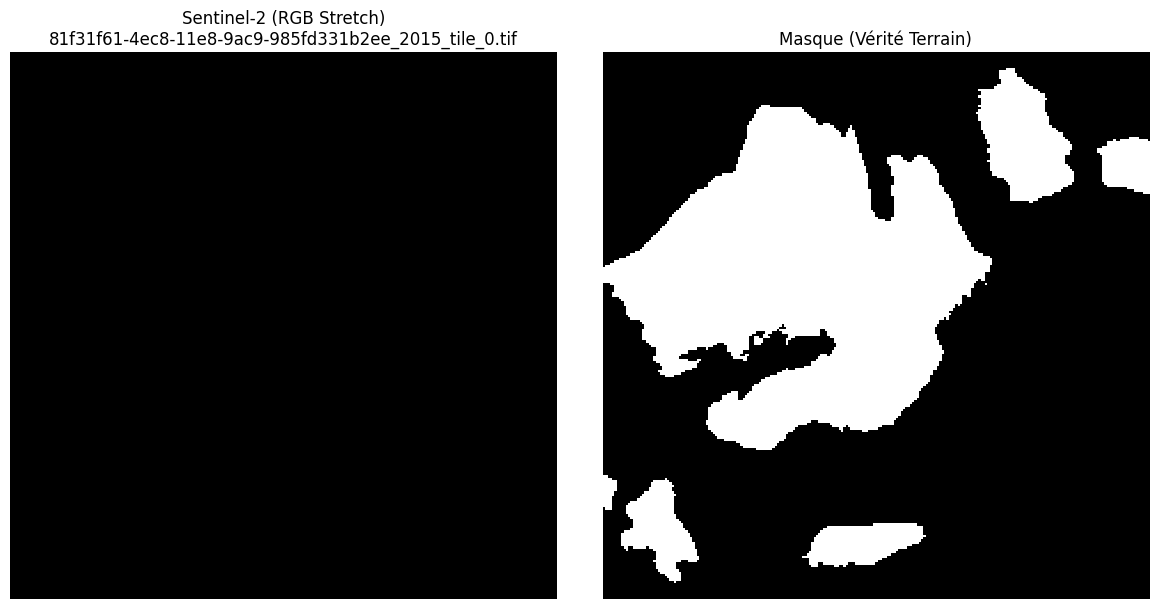

In [50]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
import random

IMAGE_DIR = "dataset/images_raw_2056"
MASK_DIR = "dataset/masks"

# Fonction pour normaliser l'image (Contrast Stretch)
def stretch_image(img_array):
    """
    Prend une image (H, W, C) et applique un étirement d'histogramme 2%-98%.
    """
    # On évite de modifier les 0 (NoData) si possible, mais ici on veut juste voir l'image
    lower = np.percentile(img_array, 2)
    upper = np.percentile(img_array, 98)
    
    # On étire les valeurs entre 0 et 1
    # np.clip s'assure qu'on ne dépasse pas 0 et 1
    img_norm = (img_array - lower) / (upper - lower)
    img_norm = np.clip(img_norm, 0, 1)
    return img_norm

# Choix aléatoire
files = [f for f in os.listdir(MASK_DIR) if f.endswith('.tif')]
if not files:
    print("Aucun fichier trouvé !")
else:
    sample_file = random.choice(files)
    print(f"Visualisation de : {sample_file}")

    img_p = os.path.join(IMAGE_DIR, sample_file)
    msk_p = os.path.join(MASK_DIR, sample_file)
    print(f"Image path: {img_p}")

    with rasterio.open(img_p) as src_img, rasterio.open(msk_p) as src_msk:
        # Rappel de l'ordre d'export GEE : ['B2', 'B3', 'B4', 'B8']
        # Indices Python (0-based) : 0=Bleu, 1=Vert, 2=Rouge, 3=NIR
        
        # Pour faire du RGB, on veut Rouge (idx 2), Vert (idx 1), Bleu (idx 0)
        # Note : rasterio.read() utilise des indices 1-based pour les bandes
        r = src_img.read(3)
        g = src_img.read(2)
        b = src_img.read(1)
        
        # On empile pour faire une image (Hauteur, Largeur, 3)
        img = np.dstack((r, g, b))
        
        # --- C'EST ICI QUE LA MAGIE OPÈRE ---
        # On convertit en float pour le calcul
        img = img.astype(np.float32)
        
        # On applique le stretch intelligent
        img_vis = stretch_image(img)
        
        # Lecture du masque
        msk = src_msk.read(1)

    # Affichage
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_vis)
    plt.title(f"Sentinel-2 (RGB Stretch)\n{sample_file}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(msk, cmap='gray', interpolation='nearest')
    plt.title("Masque (Vérité Terrain)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [54]:
import rasterio
import numpy as np
import os
import shutil
from tqdm import tqdm

# --- CONFIGURATION ---
SRC_IMG_DIR = "dataset/images_raw_2056"
SRC_MASK_DIR = "dataset/masks"

# Dossiers de destination "Propres"
CLEAN_IMG_DIR = "dataset/clean/images"
CLEAN_MASK_DIR = "dataset/clean/masks"

os.makedirs(CLEAN_IMG_DIR, exist_ok=True)
os.makedirs(CLEAN_MASK_DIR, exist_ok=True)

files = [f for f in os.listdir(SRC_IMG_DIR) if f.endswith('.tif')]
corrupted_count = 0
valid_count = 0

print(f"Début du nettoyage sur {len(files)} fichiers...")

for f in tqdm(files):
    src_img_path = os.path.join(SRC_IMG_DIR, f)
    src_mask_path = os.path.join(SRC_MASK_DIR, f)
    
    # Vérification que le masque existe bien (on ne garde pas d'orphelins)
    if not os.path.exists(src_mask_path):
        # print(f"Ignoré (Pas de masque) : {f}")
        corrupted_count += 1
        continue

    is_valid = False
    
    # Vérification du contenu (Est-ce noir ?)
    try:
        with rasterio.open(src_img_path) as src:
            # Astuce performance : src.read().max() est plus rapide que mean() 
            # et suffit pour détecter une image 100% vide (tout à 0)
            if src.read().max() > 0:
                is_valid = True
    except Exception as e:
        print(f"Erreur lecture {f}: {e}")
    
    if is_valid:
        # Copie PHYSIQUE des fichiers (plus sûr que de réécrire le raster)
        shutil.copy2(src_img_path, os.path.join(CLEAN_IMG_DIR, f))
        shutil.copy2(src_mask_path, os.path.join(CLEAN_MASK_DIR, f))
        valid_count += 1
    else:
        corrupted_count += 1

print("-" * 30)
print(f"BILAN :")
print(f"❌ Images rejetées (Vides/Orphelines) : {corrupted_count}")
print(f"✅ Paires valides copiées dans 'clean' : {valid_count}")
print("-" * 30)

Début du nettoyage sur 1575 fichiers...


100%|██████████| 1575/1575 [00:40<00:00, 38.46it/s]

------------------------------
BILAN :
❌ Images rejetées (Vides/Orphelines) : 834
✅ Paires valides copiées dans 'clean' : 741
------------------------------


# A cause des nuages, on perds 834 images

Pour mtn, on peut continuer sans elles


In [62]:
import geopandas as gpd
import os
import pandas as pd
from tqdm import tqdm

# --- CONFIGURATION ---
# Ton dossier d'images nettoyées (celles qui vont servir à l'entraînement/test)
CLEAN_IMG_DIR = "dataset/clean/images"

# Ton shapefile original (celui qui contient tout le monde, même les vieux)
ORIGINAL_SHP = "glamos/SGI_2016_wgs84.shp"

# Le nouveau fichier à créer
OUTPUT_SHP = "glamos/SGI_2016_VALID_ONLY.shp"

print("1. Scan des images disponibles...")
files = [f for f in os.listdir(CLEAN_IMG_DIR) if f.endswith('.tif')]

if not files:
    raise ValueError("Erreur : Le dossier d'images est vide !")

# Extraction des IDs uniques depuis les noms de fichiers
# Format attendu : ID_ANNEE_tile_X.tif
valid_ids = set()
for f in tqdm(files):
    # On coupe au niveau de l'année (avant-avant dernier underscore)
    parts = f.replace('.tif', '').split('_')
    # Reconstruction de l'ID (tout ce qui est avant l'année)
    # Ex: "uuid-compliqué_2016_tile_0" -> ["uuid-compliqué", "2016", "tile", "0"]
    if len(parts) >= 3:
        g_id = "_".join(parts[:-3])
        valid_ids.add(g_id)

print(f" -> {len(valid_ids)} glaciers uniques trouvés dans les images.")

print("2. Chargement du Shapefile original...")
gdf = gpd.read_file(ORIGINAL_SHP)

# Conversion de la colonne ID en string pour être sûr que ça matche
# (Parfois c'est lu comme un Objet ou Int)
gdf['pk_glacier'] = gdf['pk_glacier'].astype(str)

print("3. Filtrage...")
# On ne garde que les lignes dont l'ID est dans notre set 'valid_ids'
gdf_valid = gdf[gdf['pk_glacier'].isin(valid_ids)].copy()

print(f" -> {len(gdf_valid)} polygones conservés sur {len(gdf)} initiaux.")

print("4. Sauvegarde du nouveau Shapefile...")
# On sauvegarde (assure-toi que le dossier existe)
gdf_valid.to_file(OUTPUT_SHP)

print(f"✅ Terminé ! Nouveau fichier créé : {OUTPUT_SHP}")
print("👉 Ouvre ce fichier dans QGIS pour faire ta sélection de Test Set.")

1. Scan des images disponibles...


100%|██████████| 741/741 [00:00<00:00, 279419.16it/s]

 -> 558 glaciers uniques trouvés dans les images.
2. Chargement du Shapefile original...


3. Filtrage...
 -> 558 polygones conservés sur 1400 initiaux.
4. Sauvegarde du nouveau Shapefile...
✅ Terminé ! Nouveau fichier créé : glamos/SGI_2016_VALID_ONLY.shp
👉 Ouvre ce fichier dans QGIS pour faire ta sélection de Test Set.


![alt text](image.png)
test zone

In [66]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# --- CONFIGURATION ---
DRY_RUN = False  # <--- METTRE A FALSE POUR ACTIVER LE DÉPLACEMENT RÉEL

# Chemins
TSV_PATH = "test_set_idx.tsv"
SRC_IMG_DIR = "dataset/clean/images"
SRC_MASK_DIR = "dataset/clean/masks"
DEST_IMG_DIR = "dataset/test/images"
DEST_MASK_DIR = "dataset/test/masks"

# Création des dossiers de destination si on n'est pas en dry run (ou pour éviter les erreurs)
if not DRY_RUN:
    os.makedirs(DEST_IMG_DIR, exist_ok=True)
    os.makedirs(DEST_MASK_DIR, exist_ok=True)

# 1. Chargement des IDs cibles
print(f"📂 Chargement du TSV : {TSV_PATH}")
test_set = pd.read_csv(TSV_PATH, sep="\t")

# On crée un SET (ensemble) pour une recherche ultra-rapide
# On nettoie les espaces et guillemets potentiels
target_ids = set(test_set["pk_glacier"].astype(str).str.strip().str.replace('"', ''))

print(f"🎯 Cibles : {len(target_ids)} glaciers uniques à déplacer.")

# 2. Scan des fichiers disponibles
print(f"🔍 Scan des fichiers dans {SRC_IMG_DIR}...")
files = [f for f in os.listdir(SRC_IMG_DIR) if f.endswith('.tif')]

# Listes pour le rapport
files_to_move = []
ids_found_in_files = set()

# 3. Matching
for filename in tqdm(files, desc="Analyse des fichiers"):
    # Reconstruction de l'ID à partir du nom de fichier
    # Format : ID_ANNEE_tile_X.tif
    # On split par '_' et on enlève les 3 derniers blocs (ANNEE, tile, X.tif)
    parts = filename.replace('.tif', '').split('_')
    
    if len(parts) >= 3:
        # On recole les morceaux de l'ID (au cas où l'ID contienne des underscores)
        file_glacier_id = "_".join(parts[:-3])
        
        # Est-ce que cet ID est dans notre liste cible ?
        if file_glacier_id in target_ids:
            files_to_move.append(filename)
            ids_found_in_files.add(file_glacier_id)

# 4. Calcul des statistiques
missing_ids = target_ids - ids_found_in_files
total_tiles = len(files_to_move)

print("\n" + "="*40)
print(f"RÉSULTAT DE LA SIMULATION (Dry Run: {DRY_RUN})")
print("="*40)
print(f"🧊 Glaciers demandés (TSV) : {len(target_ids)}")
print(f"✅ Glaciers trouvés        : {len(ids_found_in_files)}")
print(f"❌ Glaciers introuvables   : {len(missing_ids)}")
print(f"📦 Total de tuiles (images): {total_tiles}")
print("-" * 40)

if len(missing_ids) > 0:
    print(f"⚠️ Exemples d'IDs manquants (top 5) : {list(missing_ids)[:5]}")
    print("(Ces glaciers sont dans le TSV mais n'ont aucune image dans 'clean'.")
    print(" Probablement filtrés car images noires ou mauvaise année).")

# 5. Exécution du déplacement
if total_tiles > 0:
    if DRY_RUN:
        print(f"\n🚀 Ceci est un test. Pour déplacer ces {total_tiles} fichiers, passe DRY_RUN = False.")
    else:
        print(f"\n🚚 Démarrage du déplacement des {total_tiles} paires...")
        moved_count = 0
        
        for filename in tqdm(files_to_move, desc="Déplacement"):
            src_img = os.path.join(SRC_IMG_DIR, filename)
            src_msk = os.path.join(SRC_MASK_DIR, filename)
            
            dst_img = os.path.join(DEST_IMG_DIR, filename)
            dst_msk = os.path.join(DEST_MASK_DIR, filename)
            
            try:
                # On utilise move (déplacement) et pas copy
                shutil.move(src_img, dst_img)
                # On bouge le masque s'il existe (normalement oui car dossier 'clean')
                if os.path.exists(src_msk):
                    shutil.move(src_msk, dst_msk)
                moved_count += 1
            except Exception as e:
                print(f"Erreur sur {filename}: {e}")
                
        print(f"\n✅ Opération terminée ! {moved_count} images déplacées dans dataset/test.")
else:
    print("\n⚠️ Rien à déplacer.")

📂 Chargement du TSV : test_set_idx.tsv
🎯 Cibles : 118 glaciers uniques à déplacer.
🔍 Scan des fichiers dans dataset/clean/images...


Analyse des fichiers: 100%|██████████| 741/741 [00:00<00:00, 204809.18it/s]



RÉSULTAT DE LA SIMULATION (Dry Run: False)
🧊 Glaciers demandés (TSV) : 118
✅ Glaciers trouvés        : 118
❌ Glaciers introuvables   : 0
📦 Total de tuiles (images): 185
----------------------------------------

🚚 Démarrage du déplacement des 185 paires...


Déplacement: 100%|██████████| 185/185 [00:00<00:00, 198.35it/s]


✅ Opération terminée ! 185 images déplacées dans dataset/test.
